In [1]:
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install required packages
packages = ["torch", "torchvision", "requests", "matplotlib", "seaborn", "scikit-learn", "tqdm", "numpy"]
for package in packages:
    try:
        __import__(package.split('==')[0])
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)

print("All packages installed successfully!")

Installing scikit-learn...
All packages installed successfully!


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import os
import random
import zipfile
import requests
import glob

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
def download_s3dis_dataset(data_dir='./s3dis_data'):
    """Download and extract S3DIS dataset"""
    url = "https://cvg-data.inf.ethz.ch/s3dis/Stanford3dDataset_v1.2_Aligned_Version.zip"

    os.makedirs(data_dir, exist_ok=True)
    zip_path = os.path.join(data_dir, "Stanford3dDataset_v1.2_Aligned_Version.zip")
    extract_path = os.path.join(data_dir, "Stanford3dDataset_v1.2_Aligned_Version")

    # Check if already downloaded and extracted
    if os.path.exists(extract_path):
        print("Dataset already exists, skipping download.")
        return extract_path

    print("Downloading S3DIS dataset...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        total_size = int(response.headers.get('content-length', 0))
        with open(zip_path, 'wb') as f, tqdm(
            desc="Downloading",
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                size = f.write(chunk)
                pbar.update(size)

        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)

        # Clean up zip file
        os.remove(zip_path)
        print("Dataset download and extraction completed!")

    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("Please download manually from the provided URL")
        return None

    return extract_path

# Download the dataset
dataset_path = download_s3dis_dataset()


Downloading: 100%|██████████| 4.09G/4.09G [03:51<00:00, 19.0MiB/s]


Extracting dataset...
Dataset download and extraction completed!


In [4]:
import os
import requests
import zipfile
from tqdm import tqdm
import glob
from os import path as osp
import numpy as np

def download_s3dis_dataset(data_dir='./s3dis_data'):
    """Download and extract S3DIS dataset"""
    url = "https://cvg-data.inf.ethz.ch/s3dis/Stanford3dDataset_v1.2_Aligned_Version.zip"

    os.makedirs(data_dir, exist_ok=True)
    zip_path = os.path.join(data_dir, "Stanford3dDataset_v1.2_Aligned_Version.zip")
    extract_path = os.path.join(data_dir, "Stanford3dDataset_v1.2_Aligned_Version")

    # Check if already downloaded and extracted
    if os.path.exists(extract_path):
        print("Dataset already exists, skipping download.")
        return extract_path

    print("Downloading S3DIS dataset...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        total_size = int(response.headers.get('content-length', 0))
        with open(zip_path, 'wb') as f, tqdm(
            desc="Downloading",
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                size = f.write(chunk)
                pbar.update(size)

        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)

        # Clean up zip file
        os.remove(zip_path)
        print("Dataset download and extraction completed!")

    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("Please download manually from the provided URL")
        return None

    return extract_path

# Download the dataset
dataset_path = download_s3dis_dataset()

# Set up paths and constants
output_folder = './s3dis_data/processed'
data_dir = dataset_path
os.makedirs(output_folder, exist_ok=True)

# S3DIS class names
class_names = [
    'ceiling', 'floor', 'wall', 'beam', 'column', 'window', 'door',
    'chair', 'table', 'bookcase', 'sofa', 'board', 'clutter'
]
class2label = {one_class: i for i, one_class in enumerate(class_names)}

# Create annotation paths by scanning dataset
anno_paths = []
for area in sorted(os.listdir(data_dir)):
    area_path = os.path.join(data_dir, area)
    if not os.path.isdir(area_path) or not area.startswith('Area_'):
        continue

    for room in sorted(os.listdir(area_path)):
        room_path = os.path.join(area_path, room)
        if not os.path.isdir(room_path):
            continue

        annotations_path = os.path.join(room_path, 'Annotations')
        if os.path.exists(annotations_path):
            anno_paths.append(annotations_path)

print(f"Found {len(anno_paths)} rooms to process")

# Fix known issue in Area_5/hallway_6
revise_file = os.path.join(data_dir, 'Area_5/hallway_6/Annotations/ceiling_1.txt')
if os.path.exists(revise_file):
    with open(revise_file, 'r') as f:
        data = f.read()
        # replace that extra character with blank space to separate data
        if len(data) > 5545348:
            data = data[:5545347] + ' ' + data[5545348:]

    with open(revise_file, 'w') as f:
        f.write(data)
    print("Fixed Area_5/hallway_6/ceiling_1.txt")

# Export function
def export(anno_path, out_filename):
    """Convert original dataset files to points, instance mask and semantic mask files"""
    points_list = []
    ins_idx = 1  # instance ids should be indexed from 1, so 0 is unannotated

    for f in glob.glob(os.path.join(anno_path, '*.txt')):
        one_class = os.path.basename(f).split('_')[0]
        if one_class not in class_names:  # some rooms have 'staris' class
            one_class = 'clutter'

        points = np.loadtxt(f)
        labels = np.ones((points.shape[0], 1)) * class2label[one_class]
        ins_labels = np.ones((points.shape[0], 1)) * ins_idx
        ins_idx += 1
        points_list.append(np.concatenate([points, labels, ins_labels], 1))

    data_label = np.concatenate(points_list, 0)  # [N, 8], (pts, rgb, sem, ins)
    xyz_min = np.amin(data_label, axis=0)[0:3]
    data_label[:, 0:3] -= xyz_min

    np.save(f'{out_filename}_point.npy', data_label[:, :6].astype(np.float32))
    np.save(f'{out_filename}_sem_label.npy', data_label[:, 6].astype(np.int32))
    np.save(f'{out_filename}_ins_label.npy', data_label[:, 7].astype(np.int32))

# Process all annotation files
for i, anno_path in enumerate(anno_paths):
    print(f'Processing ({i+1}/{len(anno_paths)}): {anno_path}')

    elements = anno_path.split('/')
    out_filename = elements[-3] + '_' + elements[-2]  # Area_1_hallway_1
    out_filename = os.path.join(output_folder, out_filename)

    if os.path.isfile(f'{out_filename}_point.npy'):
        print('File already exists. skipping.')
        continue

    try:
        export(anno_path, out_filename)
        print(f'Successfully processed: {out_filename}')
    except Exception as e:
        print(f'Error processing {anno_path}: {e}')

print("Preprocessing completed!")
print(f"Processed files are saved in: {output_folder}")

Dataset already exists, skipping download.
Found 272 rooms to process
Fixed Area_5/hallway_6/ceiling_1.txt
Processing (1/272): ./s3dis_data/Stanford3dDataset_v1.2_Aligned_Version/Area_1/WC_1/Annotations
Successfully processed: ./s3dis_data/processed/Area_1_WC_1
Processing (2/272): ./s3dis_data/Stanford3dDataset_v1.2_Aligned_Version/Area_1/conferenceRoom_1/Annotations
Successfully processed: ./s3dis_data/processed/Area_1_conferenceRoom_1
Processing (3/272): ./s3dis_data/Stanford3dDataset_v1.2_Aligned_Version/Area_1/conferenceRoom_2/Annotations
Successfully processed: ./s3dis_data/processed/Area_1_conferenceRoom_2
Processing (4/272): ./s3dis_data/Stanford3dDataset_v1.2_Aligned_Version/Area_1/copyRoom_1/Annotations
Successfully processed: ./s3dis_data/processed/Area_1_copyRoom_1
Processing (5/272): ./s3dis_data/Stanford3dDataset_v1.2_Aligned_Version/Area_1/hallway_1/Annotations
Successfully processed: ./s3dis_data/processed/Area_1_hallway_1
Processing (6/272): ./s3dis_data/Stanford3dDatas

Loading and visualizing S3DIS sample...
Loading sample: Area_5_hallway_15
Sample: Area_5_hallway_15
Total points: 1,280,664
Point cloud bounds:
  X: [0.00, 13.65]
  Y: [0.00, 3.27]
  Z: [0.00, 3.26]
Unique classes: 7
Unique instances: 14
--------------------------------------------------
Downsampled to 100,000 points for visualization
1. RGB Point Cloud Visualization


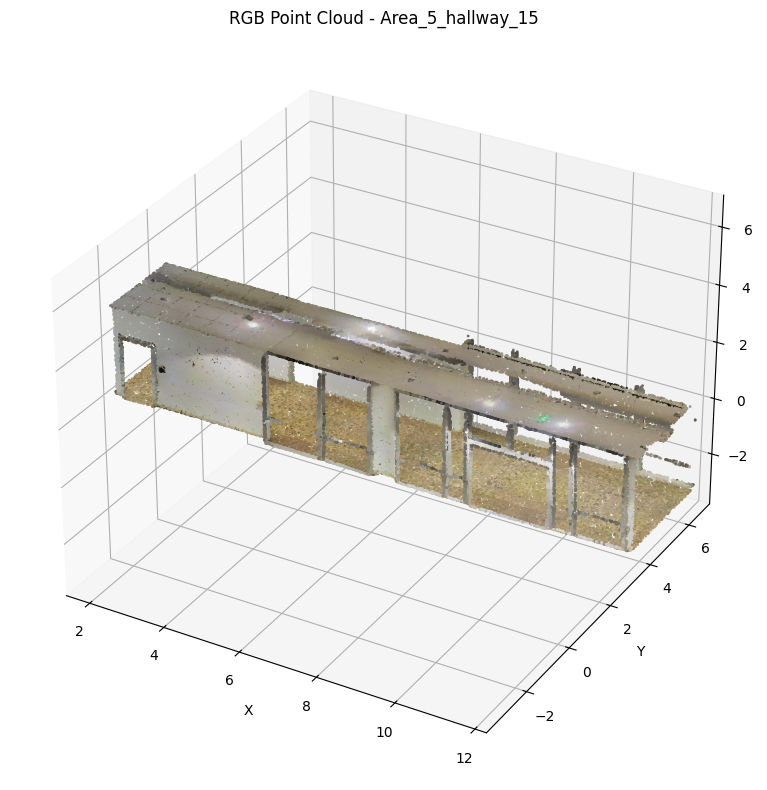

2. Semantic Segmentation Visualization


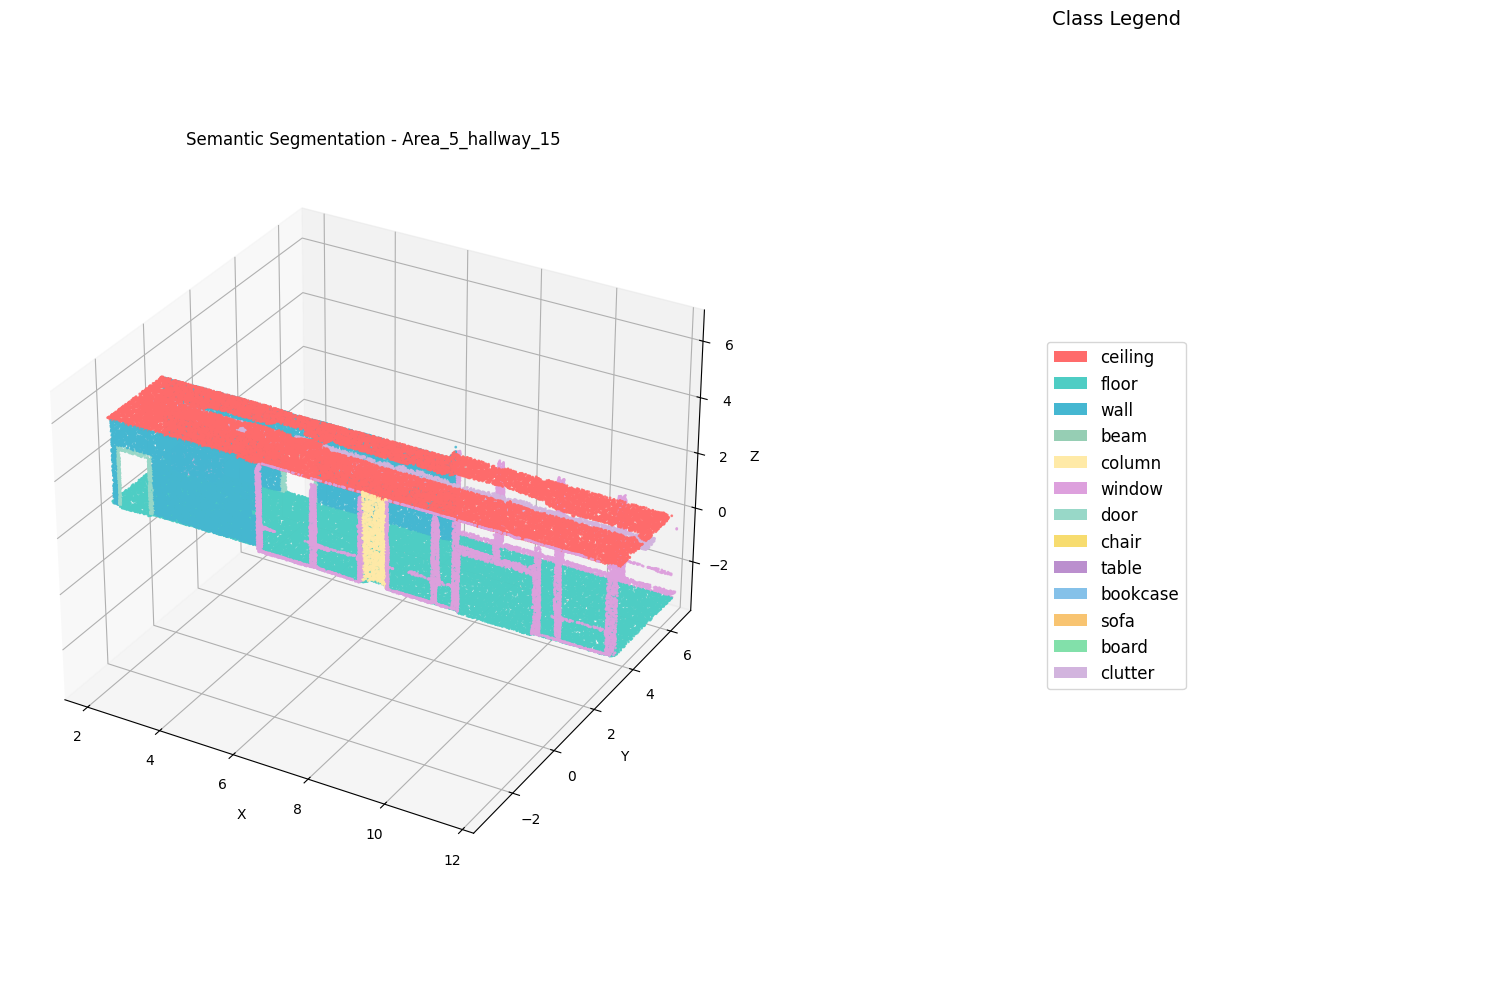

3. Top-Down Views


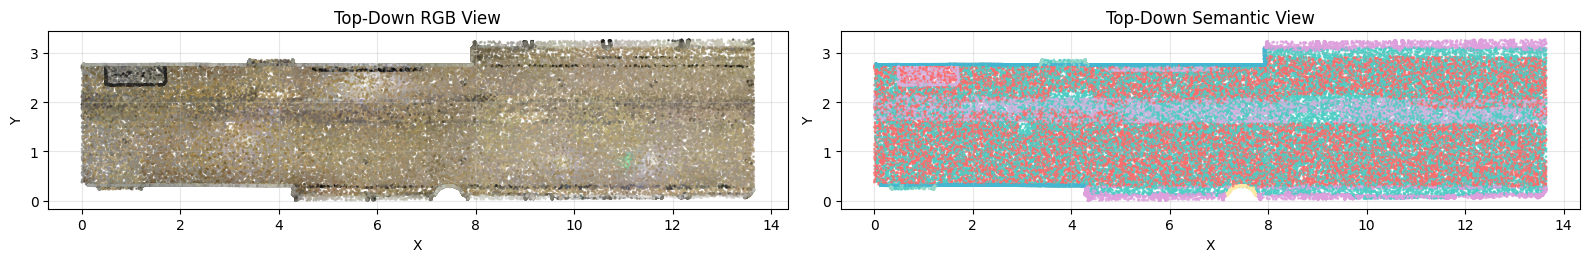

4. Class Distribution Analysis


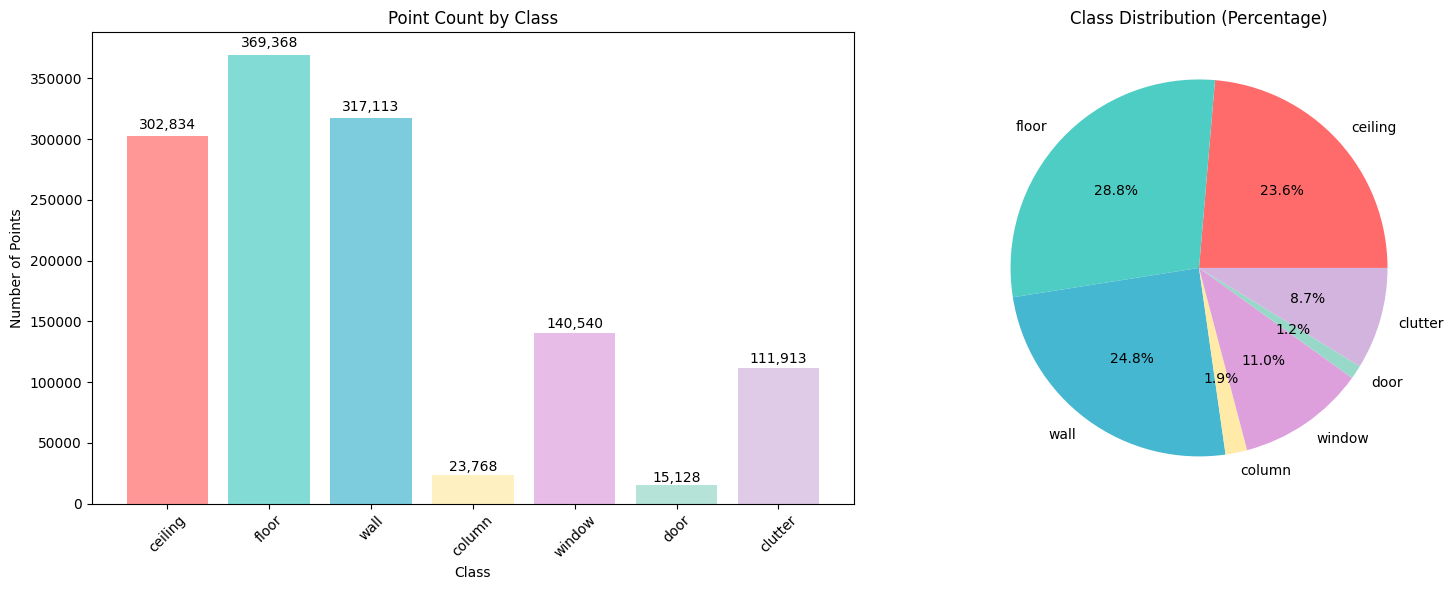


Visualizing multiple samples for comparison...


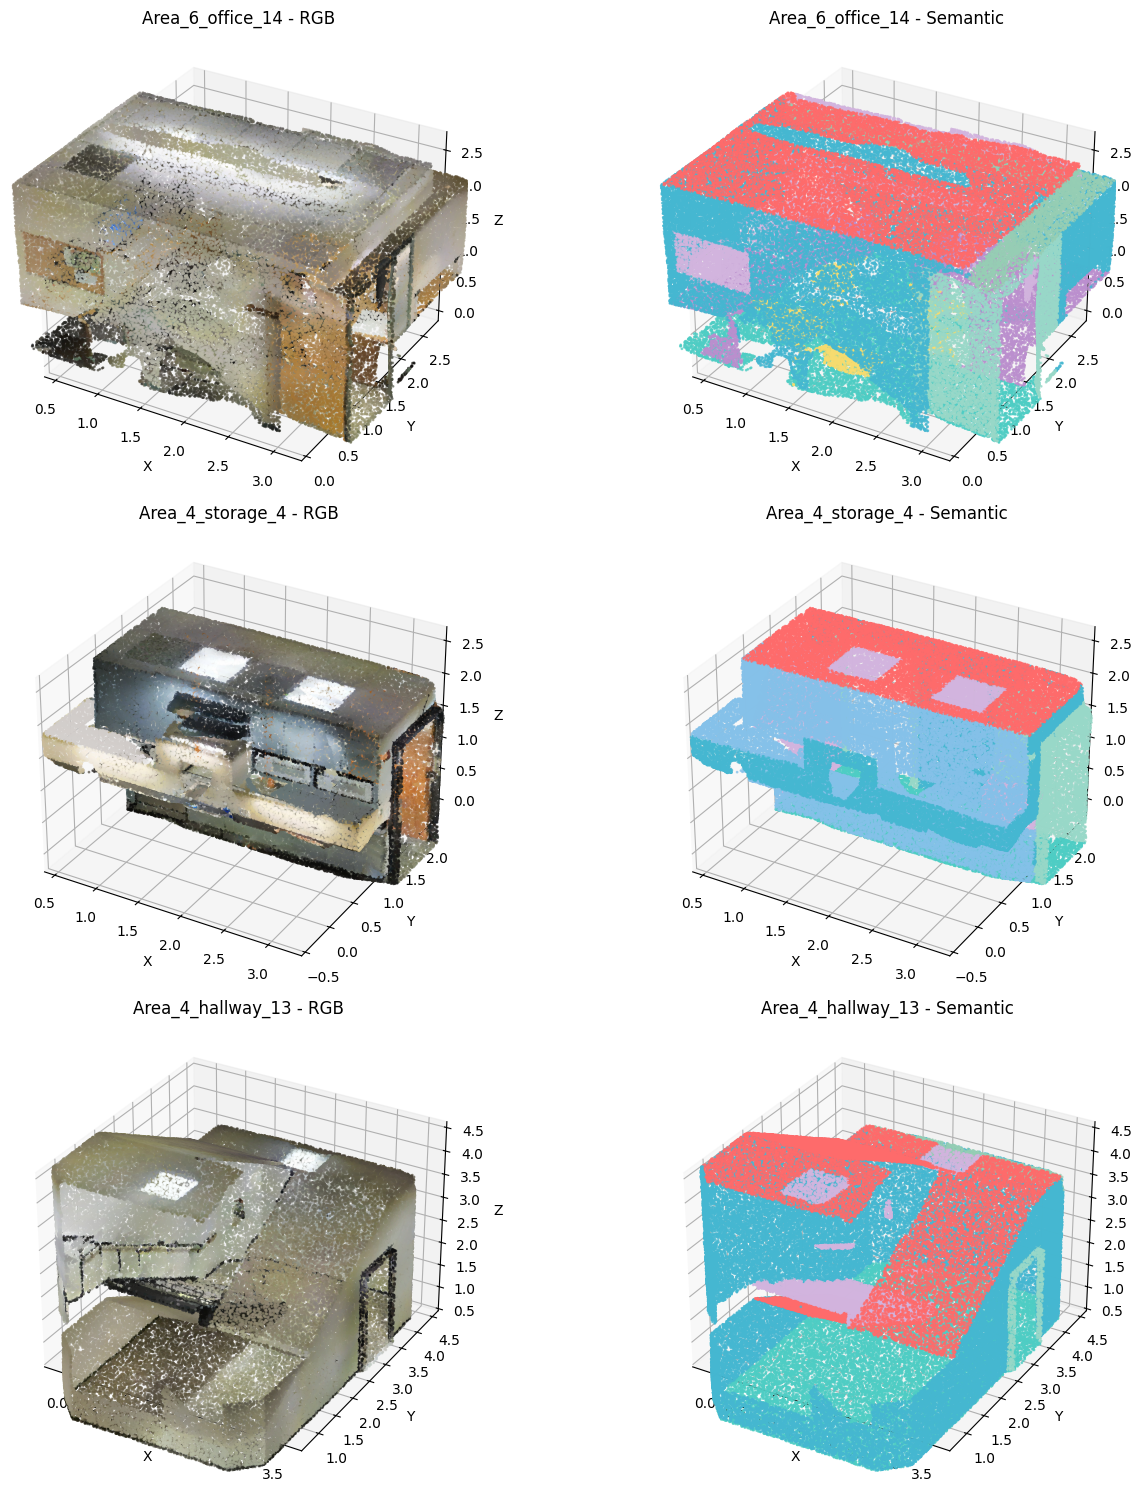

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import random
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib.patches import Patch

# S3DIS class names and colors
class_names = [
    'ceiling', 'floor', 'wall', 'beam', 'column', 'window', 'door',
    'chair', 'table', 'bookcase', 'sofa', 'board', 'clutter'
]

# Define distinct colors for each class
class_colors = [
    '#FF6B6B',  # ceiling - red
    '#4ECDC4',  # floor - teal
    '#45B7D1',  # wall - blue
    '#96CEB4',  # beam - green
    '#FFEAA7',  # column - yellow
    '#DDA0DD',  # window - plum
    '#98D8C8',  # door - mint
    '#F7DC6F',  # chair - light yellow
    '#BB8FCE',  # table - light purple
    '#85C1E9',  # bookcase - light blue
    '#F8C471',  # sofa - orange
    '#82E0AA',  # board - light green
    '#D2B4DE'   # clutter - lavender
]

def load_sample_data(data_dir='./s3dis_data/processed'):
    """Load a random sample from the processed S3DIS data"""
    point_files = [f for f in os.listdir(data_dir) if f.endswith('_point.npy')]

    if not point_files:
        print("No processed files found! Make sure to run the preprocessing first.")
        return None, None, None, None

    selected_file = random.choice(point_files)
    base_name = selected_file.replace('_point.npy', '')
    print(f"Loading sample: {base_name}")

    points = np.load(os.path.join(data_dir, f'{base_name}_point.npy'))
    sem_labels = np.load(os.path.join(data_dir, f'{base_name}_sem_label.npy'))
    ins_labels = np.load(os.path.join(data_dir, f'{base_name}_ins_label.npy'))

    return points, sem_labels, ins_labels, base_name

def downsample_points(points, labels, ins_labels, max_points=100000):
    """Downsample points for faster visualization"""
    if len(points) <= max_points:
        return points, labels, ins_labels
    indices = np.random.choice(len(points), max_points, replace=False)
    return points[indices], labels[indices], ins_labels[indices]

def auto_point_size(num_points):
    """Dynamically determine point size"""
    if num_points > 100000:
        return 0.5
    elif num_points > 50000:
        return 1
    else:
        return 2

def set_equal_aspect(ax, x, y, z, zoom=1.0):
    """Set equal aspect ratio and zoom in for better visualization"""
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0 * zoom
    mid_x = (x.max() + x.min()) * 0.5
    mid_y = (y.max() + y.min()) * 0.5
    mid_z = (z.max() + z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

def visualize_rgb_point_cloud(points, title="RGB Point Cloud"):
    """Visualize point cloud with original RGB colors"""
    s = auto_point_size(len(points))
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    colors = points[:, 3:6] / 255.0

    ax.scatter(x, y, z, c=colors, s=s, alpha=0.8)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    set_equal_aspect(ax, x, y, z, zoom=0.8)
    plt.tight_layout()
    plt.show()

def visualize_semantic_segmentation(points, sem_labels, title="Semantic Segmentation"):
    """Visualize point cloud colored by semantic classes"""
    s = auto_point_size(len(points))
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(121, projection='3d')

    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    colors = [class_colors[int(label)] for label in sem_labels]

    ax1.scatter(x, y, z, c=colors, s=s, alpha=0.8)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(title)
    set_equal_aspect(ax1, x, y, z, zoom=0.8)

    ax2 = fig.add_subplot(122)
    ax2.axis('off')
    legend_elements = [Patch(facecolor=class_colors[i], label=class_names[i]) for i in range(len(class_names))]
    ax2.legend(handles=legend_elements, loc='center', fontsize=12)
    ax2.set_title('Class Legend', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

def visualize_top_down_view(points, sem_labels, title="Top-Down Semantic View"):
    """Visualize top-down view of the room"""
    s = auto_point_size(len(points))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    x, y = points[:, 0], points[:, 1]

    colors_rgb = points[:, 3:6] / 255.0
    ax1.scatter(x, y, c=colors_rgb, s=s, alpha=0.6)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title('Top-Down RGB View')
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)

    colors_sem = [class_colors[int(label)] for label in sem_labels]
    ax2.scatter(x, y, c=colors_sem, s=s, alpha=0.7)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Top-Down Semantic View')
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_class_distribution(sem_labels, title="Class Distribution"):
    """Plot distribution of semantic classes"""
    unique_labels, counts = np.unique(sem_labels, return_counts=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    class_names_present = [class_names[int(label)] for label in unique_labels]
    colors_present = [class_colors[int(label)] for label in unique_labels]

    bars = ax1.bar(class_names_present, counts, color=colors_present, alpha=0.7)
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Points')
    ax1.set_title('Point Count by Class')
    ax1.tick_params(axis='x', rotation=45)

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{count:,}', ha='center', va='bottom', fontsize=10)

    ax2.pie(counts, labels=class_names_present, colors=colors_present, autopct='%1.1f%%')
    ax2.set_title('Class Distribution (Percentage)')
    plt.tight_layout()
    plt.show()

def visualize_sample_complete():
    """Complete visualization of a random sample"""
    print("Loading and visualizing S3DIS sample...")
    points, sem_labels, ins_labels, sample_name = load_sample_data()
    if points is None:
        return

    print(f"Sample: {sample_name}")
    print(f"Total points: {len(points):,}")
    print(f"Point cloud bounds:")
    print(f"  X: [{points[:, 0].min():.2f}, {points[:, 0].max():.2f}]")
    print(f"  Y: [{points[:, 1].min():.2f}, {points[:, 1].max():.2f}]")
    print(f"  Z: [{points[:, 2].min():.2f}, {points[:, 2].max():.2f}]")
    print(f"Unique classes: {len(np.unique(sem_labels))}")
    print(f"Unique instances: {len(np.unique(ins_labels))}")
    print("-" * 50)

    points_viz, sem_viz, ins_viz = downsample_points(points, sem_labels, ins_labels, 100000)
    print(f"Downsampled to {len(points_viz):,} points for visualization")

    print("1. RGB Point Cloud Visualization")
    visualize_rgb_point_cloud(points_viz, f"RGB Point Cloud - {sample_name}")

    print("2. Semantic Segmentation Visualization")
    visualize_semantic_segmentation(points_viz, sem_viz, f"Semantic Segmentation - {sample_name}")

    print("3. Top-Down Views")
    visualize_top_down_view(points_viz, sem_viz, f"Top-Down Views - {sample_name}")

    print("4. Class Distribution Analysis")
    plot_class_distribution(sem_labels, f"Class Distribution - {sample_name}")

def visualize_multiple_samples(num_samples=3):
    """Visualize multiple samples for comparison"""
    data_dir = './s3dis_data/processed'
    point_files = [f for f in os.listdir(data_dir) if f.endswith('_point.npy')]
    if len(point_files) < num_samples:
        num_samples = len(point_files)
    selected_files = random.sample(point_files, num_samples)

    fig = plt.figure(figsize=(15, 5 * num_samples))
    for i, file in enumerate(selected_files):
        base_name = file.replace('_point.npy', '')
        points = np.load(os.path.join(data_dir, f'{base_name}_point.npy'))
        sem_labels = np.load(os.path.join(data_dir, f'{base_name}_sem_label.npy'))

        if len(points) > 100000:
            indices = np.random.choice(len(points), 100000, replace=False)
            points = points[indices]
            sem_labels = sem_labels[indices]

        s = auto_point_size(len(points))
        ax1 = fig.add_subplot(num_samples, 2, 2*i + 1, projection='3d')
        x, y, z = points[:, 0], points[:, 1], points[:, 2]
        colors = points[:, 3:6] / 255.0
        ax1.scatter(x, y, z, c=colors, s=s, alpha=0.6)
        ax1.set_title(f'{base_name} - RGB')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        set_equal_aspect(ax1, x, y, z, zoom=0.8)

        ax2 = fig.add_subplot(num_samples, 2, 2*i + 2, projection='3d')
        colors_sem = [class_colors[int(label)] for label in sem_labels]
        ax2.scatter(x, y, z, c=colors_sem, s=s, alpha=0.7)
        ax2.set_title(f'{base_name} - Semantic')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
        set_equal_aspect(ax2, x, y, z, zoom=0.8)

    plt.tight_layout()
    plt.show()

# Run complete visualization
visualize_sample_complete()

print("\n" + "="*60)
print("Visualizing multiple samples for comparison...")
visualize_multiple_samples(3)


# pointnet

In [6]:
class STN3d(nn.Module):
    """3D Spatial Transformer Network for input point cloud transformation"""
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batch_size = x.size(0)

        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # Max pooling
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        # Fully connected layers
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        # Add identity matrix
        identity = torch.eye(3, dtype=torch.float32, device=x.device)
        identity = identity.view(1, 9).repeat(batch_size, 1)
        x = x + identity
        x = x.view(-1, 3, 3)

        return x

In [7]:
class STNkd(nn.Module):
    """k-dimensional Spatial Transformer Network"""
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.k = k

        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batch_size = x.size(0)

        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # Max pooling
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        # Fully connected layers
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        # Add identity matrix
        identity = torch.eye(self.k, dtype=torch.float32, device=x.device)
        identity = identity.view(1, self.k * self.k).repeat(batch_size, 1)
        x = x + identity
        x = x.view(-1, self.k, self.k)

        return x

In [8]:
class PointNetFeatureExtractor(nn.Module):
    """PointNet feature extraction backbone"""
    def __init__(self, global_feat=True, feature_transform=False):
        super(PointNetFeatureExtractor, self).__init__()
        self.global_feat = global_feat
        self.feature_transform = feature_transform

        # Input transformation
        self.input_transform = STN3d()

        # First set of convolutions
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        # Feature transformation
        if self.feature_transform:
            self.feature_transform_net = STNkd(k=64)

    def forward(self, x):
        n_pts = x.size()[2]

        # Input transformation
        trans_input = self.input_transform(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans_input)
        x = x.transpose(2, 1)

        # First convolution
        x = F.relu(self.bn1(self.conv1(x)))

        # Feature transformation
        if self.feature_transform:
            trans_feat = self.feature_transform_net(x)
            x = x.transpose(2, 1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2, 1)
        else:
            trans_feat = None

        # Store point features for segmentation
        point_feat = x

        # Continue feature extraction
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        # Global max pooling
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        if self.global_feat:
            return x, trans_input, trans_feat
        else:
            # For segmentation, concatenate global and local features
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, point_feat], 1), trans_input, trans_feat

In [9]:
class PointNetSegmentation(nn.Module):
    """PointNet for semantic segmentation"""
    def __init__(self, num_classes, feature_transform=False):
        super(PointNetSegmentation, self).__init__()
        self.num_classes = num_classes
        self.feature_transform = feature_transform

        # Feature extractor
        self.feat = PointNetFeatureExtractor(global_feat=False,
                                           feature_transform=feature_transform)

        # Segmentation head
        self.conv1 = nn.Conv1d(1088, 512, 1)  # 1024 + 64 = 1088
        self.conv2 = nn.Conv1d(512, 256, 1)
        self.conv3 = nn.Conv1d(256, 128, 1)
        self.conv4 = nn.Conv1d(128, num_classes, 1)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batch_size = x.size()[0]
        n_pts = x.size()[2]

        # Extract features
        x, trans_input, trans_feat = self.feat(x)

        # Segmentation layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)

        x = x.transpose(2, 1).contiguous()
        x = F.log_softmax(x.view(-1, self.num_classes), dim=-1)
        x = x.view(batch_size, n_pts, self.num_classes)

        return x, trans_input, trans_feat

def feature_transform_regularizer(trans):
    """Regularization loss for feature transformation matrix"""
    d = trans.size()[1]
    batch_size = trans.size()[0]
    I = torch.eye(d, device=trans.device)[None, :, :]
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2, 1)) - I, dim=(1, 2)))
    return loss

# Training

In [10]:
class S3DISDataset(Dataset):
    """S3DIS dataset for semantic segmentation"""
    def __init__(self, data_dir, num_points=4096, split='train', test_area=5):
        self.data_dir = data_dir
        self.num_points = num_points
        self.split = split
        self.test_area = test_area

        # Get all processed files
        self.data_list = []
        point_files = [f for f in os.listdir(data_dir) if f.endswith('_point.npy')]

        for file in point_files:
            area_num = int(file.split('_')[1])  # Extract area number
            if split == 'train' and area_num != test_area:
                self.data_list.append(file.replace('_point.npy', ''))
            elif split == 'test' and area_num == test_area:
                self.data_list.append(file.replace('_point.npy', ''))

        print(f"{split.upper()} set: {len(self.data_list)} samples")

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        base_name = self.data_list[idx]

        # Load data
        points = np.load(os.path.join(self.data_dir, f'{base_name}_point.npy'))
        labels = np.load(os.path.join(self.data_dir, f'{base_name}_sem_label.npy'))

        # Extract coordinates only (xyz)
        coords = points[:, :3].astype(np.float32)

        # Randomly sample points
        if len(coords) >= self.num_points:
            choice = np.random.choice(len(coords), self.num_points, replace=False)
        else:
            choice = np.random.choice(len(coords), self.num_points, replace=True)

        coords = coords[choice]
        labels = labels[choice]

        # Normalize coordinates
        coords = self.normalize_coords(coords)

        return torch.FloatTensor(coords), torch.LongTensor(labels)

    def normalize_coords(self, coords):
        """Normalize coordinates to unit sphere"""
        centroid = np.mean(coords, axis=0)
        coords = coords - centroid
        m = np.max(np.sqrt(np.sum(coords**2, axis=1)))
        coords = coords / m
        return coords


In [11]:
def calculate_accuracy(pred, target):
    """Calculate point-wise accuracy"""
    pred_choice = pred.data.max(2)[1]
    correct = pred_choice.eq(target.data).cpu().sum()
    return correct.item() / (target.size(0) * target.size(1))

def calculate_iou(pred, target, num_classes):
    """Calculate mean IoU"""
    pred = pred.data.max(2)[1].cpu().numpy()
    target = target.cpu().numpy()

    ious = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)

        if target_cls.sum() == 0:  # No ground truth for this class
            if pred_cls.sum() == 0:  # No prediction either
                ious.append(1.0)
            else:  # False positives
                ious.append(0.0)
        else:
            intersection = (pred_cls & target_cls).sum()
            union = (pred_cls | target_cls).sum()
            ious.append(intersection / union)

    return np.mean(ious)

In [12]:
# Training function
def train_epoch(model, train_loader, optimizer, criterion, device, feature_transform=False):
    model.train()
    total_loss = 0
    total_acc = 0
    total_iou = 0
    num_batches = len(train_loader)

    pbar = tqdm(train_loader, desc='Training')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        data = data.transpose(2, 1)  # [B, 3, N]

        optimizer.zero_grad()

        pred, trans_input, trans_feat = model(data)

        # Reshape for loss calculation
        pred = pred.view(-1, pred.size(-1))
        target = target.view(-1)

        # Main loss
        loss = criterion(pred, target)

        # Regularization loss for transformation matrices
        if feature_transform and trans_feat is not None:
            reg_loss = feature_transform_regularizer(trans_feat)
            loss += 0.001 * reg_loss

        loss.backward()
        optimizer.step()

        # Calculate metrics
        pred_reshaped = pred.view(data.size(0), -1, pred.size(-1))
        target_reshaped = target.view(data.size(0), -1)

        acc = calculate_accuracy(pred_reshaped, target_reshaped)
        iou = calculate_iou(pred_reshaped, target_reshaped, model.num_classes)

        total_loss += loss.item()
        total_acc += acc
        total_iou += iou

        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{acc:.4f}',
            'mIoU': f'{iou:.4f}'
        })

    return total_loss / num_batches, total_acc / num_batches, total_iou / num_batches

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_iou = 0
    num_batches = len(val_loader)

    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            data = data.transpose(2, 1)  # [B, 3, N]

            pred, _, _ = model(data)

            # Reshape for loss calculation
            pred_flat = pred.view(-1, pred.size(-1))
            target_flat = target.view(-1)

            loss = criterion(pred_flat, target_flat)

            # Calculate metrics
            acc = calculate_accuracy(pred, target)
            iou = calculate_iou(pred, target, model.num_classes)

            total_loss += loss.item()
            total_acc += acc
            total_iou += iou

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{acc:.4f}',
                'mIoU': f'{iou:.4f}'
            })

    return total_loss / num_batches, total_acc / num_batches, total_iou / num_batches


In [13]:
def main():
    # Hyperparameters
    batch_size = 16
    num_points = 4096
    num_epochs = 100
    learning_rate = 0.001
    test_area = 5  # Area 5 for testing
    feature_transform = True

    # Data loading
    data_dir = './s3dis_data/processed'
    train_dataset = S3DISDataset(data_dir, num_points=num_points,
                                split='train', test_area=test_area)
    test_dataset = S3DISDataset(data_dir, num_points=num_points,
                               split='test', test_area=test_area)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=2, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2, drop_last=False)

    # Model, loss, optimizer
    num_classes = 13  # S3DIS has 13 classes
    model = PointNetSegmentation(num_classes=num_classes,
                                feature_transform=feature_transform).to(device)

    # Use weighted loss to handle class imbalance
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Training on {len(train_dataset)} samples, testing on {len(test_dataset)} samples")

    # Training loop
    best_iou = 0
    train_losses, train_accs, train_ious = [], [], []
    val_losses, val_accs, val_ious = [], [], []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Train
        train_loss, train_acc, train_iou = train_epoch(
            model, train_loader, optimizer, criterion, device, feature_transform
        )

        # Validate
        val_loss, val_acc, val_iou = validate_epoch(
            model, test_loader, criterion, device
        )

        scheduler.step()

        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_ious.append(train_iou)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_ious.append(val_iou)

        print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, mIoU: {train_iou:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, mIoU: {val_iou:.4f}')

        # Save best model
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), 'best_pointnet_s3dis.pth')
            print(f'New best mIoU: {best_iou:.4f} - Model saved!')

    # Save final checkpoint with complete training state
    final_checkpoint = {
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_iou': best_iou,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'train_ious': train_ious,
        'val_ious': val_ious,
        'hyperparameters': {
            'batch_size': batch_size,
            'num_points': num_points,
            'learning_rate': learning_rate,
            'test_area': test_area,
            'feature_transform': feature_transform,
            'num_classes': num_classes
        }
    }

    torch.save(final_checkpoint, 'final_checkpoint_pointnet_s3dis.pth')
    print(f'\nFinal checkpoint saved with best mIoU: {best_iou:.4f}')

    # Plot training curves
    plot_training_curves(train_losses, val_losses, train_accs, val_accs,
                        train_ious, val_ious)

    return model, (train_losses, val_losses, train_accs, val_accs, train_ious, val_ious)

In [14]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs,
                        train_ious, val_ious):
    """Plot training and validation curves"""
    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Loss
    axes[0].plot(epochs, train_losses, 'b-', label='Train Loss')
    axes[0].plot(epochs, val_losses, 'r-', label='Val Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy
    axes[1].plot(epochs, train_accs, 'b-', label='Train Acc')
    axes[1].plot(epochs, val_accs, 'r-', label='Val Acc')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # mIoU
    axes[2].plot(epochs, train_ious, 'b-', label='Train mIoU')
    axes[2].plot(epochs, val_ious, 'r-', label='Val mIoU')
    axes[2].set_title('Training and Validation mIoU')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('mIoU')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

# Evaluation and visualization functions
def evaluate_model(model, test_loader, device, class_names):
    """Detailed evaluation of the model"""
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            data = data.transpose(2, 1)

            pred, _, _ = model(data)
            pred_choice = pred.data.max(2)[1]

            all_preds.append(pred_choice.cpu().numpy())
            all_targets.append(target.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0).flatten()
    all_targets = np.concatenate(all_targets, axis=0).flatten()

    # Calculate per-class IoU
    class_ious = []
    for cls in range(len(class_names)):
        pred_cls = (all_preds == cls)
        target_cls = (all_targets == cls)

        if target_cls.sum() == 0:
            if pred_cls.sum() == 0:
                class_ious.append(1.0)
            else:
                class_ious.append(0.0)
        else:
            intersection = (pred_cls & target_cls).sum()
            union = (pred_cls | target_cls).sum()
            class_ious.append(intersection / union)

    # Print results
    print("\nPer-class IoU:")
    print("-" * 40)
    for i, (name, iou) in enumerate(zip(class_names, class_ious)):
        print(f"{name:12s}: {iou:.4f}")
    print("-" * 40)
    print(f"Mean IoU: {np.mean(class_ious):.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plot_confusion_matrix(cm, class_names)

    return np.mean(class_ious), class_ious

def plot_confusion_matrix(cm, class_names):
    """Plot confusion matrix"""
    plt.figure(figsize=(12, 10))

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataset, device, num_samples=3):
    """Visualize model predictions"""
    model.eval()

    fig = plt.figure(figsize=(20, 6 * num_samples))

    for i in range(num_samples):
        # Get random sample
        idx = random.randint(0, len(dataset) - 1)
        data, target = dataset[idx]
        data = data.unsqueeze(0).to(device)
        target = target.unsqueeze(0).to(device)

        # Get prediction
        with torch.no_grad():
            data_input = data.transpose(2, 1)
            pred, _, _ = model(data_input)
            pred_choice = pred.data.max(2)[1]

        # Convert to numpy
        points = data.cpu().numpy()[0]
        target_np = target.cpu().numpy()[0]
        pred_np = pred_choice.cpu().numpy()[0]

        # Plot ground truth
        ax1 = fig.add_subplot(num_samples, 2, 2*i + 1, projection='3d')
        colors_gt = [class_colors[int(label)] for label in target_np]
        ax1.scatter(points[:, 0], points[:, 1], points[:, 2],
                   c=colors_gt, s=1, alpha=0.7)
        ax1.set_title(f'Sample {i+1} - Ground Truth')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')

        # Plot prediction
        ax2 = fig.add_subplot(num_samples, 2, 2*i + 2, projection='3d')
        colors_pred = [class_colors[int(label)] for label in pred_np]
        ax2.scatter(points[:, 0], points[:, 1], points[:, 2],
                   c=colors_pred, s=1, alpha=0.7)
        ax2.set_title(f'Sample {i+1} - Prediction')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')

    plt.tight_layout()
    plt.show()

# Running

Starting PointNet training for S3DIS semantic segmentation...
Device: cuda
TRAIN set: 204 samples
TEST set: 68 samples
Model parameters: 3,528,790
Training on 204 samples, testing on 68 samples

Epoch 1/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, Loss=2.2885, Acc=0.3412, mIoU=0.2057]


Train Loss: 2.3891, Acc: 0.2881, mIoU: 0.0725
Val Loss: 2.2833, Acc: 0.3343, mIoU: 0.1431
New best mIoU: 0.1431 - Model saved!

Epoch 2/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, Loss=2.2898, Acc=0.3741, mIoU=0.2211]


Train Loss: 1.8194, Acc: 0.4704, mIoU: 0.1114
Val Loss: 2.2770, Acc: 0.3709, mIoU: 0.1582
New best mIoU: 0.1582 - Model saved!

Epoch 3/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it, Loss=1.4904, Acc=0.5574, mIoU=0.2802]


Train Loss: 1.5559, Acc: 0.5372, mIoU: 0.1485
Val Loss: 1.5847, Acc: 0.5238, mIoU: 0.2127
New best mIoU: 0.2127 - Model saved!

Epoch 4/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s, Loss=1.5299, Acc=0.5279, mIoU=0.2783]


Train Loss: 1.4720, Acc: 0.5490, mIoU: 0.1595
Val Loss: 1.5875, Acc: 0.4900, mIoU: 0.1797

Epoch 5/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it, Loss=1.3831, Acc=0.5452, mIoU=0.2038]


Train Loss: 1.3992, Acc: 0.5679, mIoU: 0.1730
Val Loss: 1.4104, Acc: 0.5498, mIoU: 0.1778

Epoch 6/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it, Loss=1.2839, Acc=0.5647, mIoU=0.2114]


Train Loss: 1.3260, Acc: 0.5850, mIoU: 0.1974
Val Loss: 1.3218, Acc: 0.5655, mIoU: 0.1874

Epoch 7/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it, Loss=1.2745, Acc=0.5549, mIoU=0.2313]


Train Loss: 1.2863, Acc: 0.6007, mIoU: 0.2129
Val Loss: 1.3055, Acc: 0.5549, mIoU: 0.1996

Epoch 8/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it, Loss=1.4974, Acc=0.4803, mIoU=0.1949]


Train Loss: 1.2749, Acc: 0.5985, mIoU: 0.2370
Val Loss: 1.4726, Acc: 0.4949, mIoU: 0.1744

Epoch 9/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it, Loss=1.2056, Acc=0.6013, mIoU=0.3355]


Train Loss: 1.2348, Acc: 0.6087, mIoU: 0.2564
Val Loss: 1.2680, Acc: 0.5847, mIoU: 0.2644
New best mIoU: 0.2644 - Model saved!

Epoch 10/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it, Loss=1.2738, Acc=0.6010, mIoU=0.3138]


Train Loss: 1.1899, Acc: 0.6195, mIoU: 0.2697
Val Loss: 1.3453, Acc: 0.5779, mIoU: 0.2373

Epoch 11/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it, Loss=1.3816, Acc=0.5578, mIoU=0.2879]


Train Loss: 1.2277, Acc: 0.6048, mIoU: 0.2561
Val Loss: 1.4518, Acc: 0.5670, mIoU: 0.2379

Epoch 12/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it, Loss=1.2992, Acc=0.5553, mIoU=0.3107]


Train Loss: 1.1701, Acc: 0.6262, mIoU: 0.2762
Val Loss: 1.4227, Acc: 0.5626, mIoU: 0.2418

Epoch 13/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it, Loss=1.2545, Acc=0.5663, mIoU=0.2485]


Train Loss: 1.1783, Acc: 0.6162, mIoU: 0.2603
Val Loss: 1.3346, Acc: 0.5687, mIoU: 0.2068

Epoch 14/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it, Loss=1.4222, Acc=0.5410, mIoU=0.2797]


Train Loss: 1.1502, Acc: 0.6309, mIoU: 0.2885
Val Loss: 1.4405, Acc: 0.5591, mIoU: 0.2335

Epoch 15/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:12<00:00,  2.49s/it, Loss=1.4161, Acc=0.5873, mIoU=0.3156]


Train Loss: 1.1166, Acc: 0.6333, mIoU: 0.2961
Val Loss: 1.4628, Acc: 0.5670, mIoU: 0.2457

Epoch 16/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it, Loss=1.3168, Acc=0.5837, mIoU=0.3067]


Train Loss: 1.1447, Acc: 0.6308, mIoU: 0.2767
Val Loss: 1.3821, Acc: 0.5626, mIoU: 0.2418

Epoch 17/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:13<00:00,  2.61s/it, Loss=1.4138, Acc=0.5460, mIoU=0.2875]


Train Loss: 1.1252, Acc: 0.6274, mIoU: 0.2817
Val Loss: 1.4993, Acc: 0.5500, mIoU: 0.2336

Epoch 18/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.80s/it, Loss=1.2791, Acc=0.6273, mIoU=0.3440]


Train Loss: 1.0869, Acc: 0.6445, mIoU: 0.3021
Val Loss: 1.3709, Acc: 0.5892, mIoU: 0.2500

Epoch 19/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:12<00:00,  2.57s/it, Loss=1.1285, Acc=0.6132, mIoU=0.2535]


Train Loss: 1.0909, Acc: 0.6430, mIoU: 0.3063
Val Loss: 1.1965, Acc: 0.5971, mIoU: 0.2331

Epoch 20/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.80s/it, Loss=1.2098, Acc=0.5903, mIoU=0.2786]


Train Loss: 1.0650, Acc: 0.6478, mIoU: 0.2963
Val Loss: 1.2466, Acc: 0.5993, mIoU: 0.2475

Epoch 21/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it, Loss=1.2572, Acc=0.6022, mIoU=0.2669]


Train Loss: 1.0388, Acc: 0.6520, mIoU: 0.3258
Val Loss: 1.3041, Acc: 0.5967, mIoU: 0.2362

Epoch 22/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, Loss=1.0798, Acc=0.6202, mIoU=0.3090]


Train Loss: 1.0238, Acc: 0.6617, mIoU: 0.3237
Val Loss: 1.1084, Acc: 0.6248, mIoU: 0.2816
New best mIoU: 0.2816 - Model saved!

Epoch 23/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it, Loss=1.1561, Acc=0.5957, mIoU=0.2876]


Train Loss: 0.9705, Acc: 0.6760, mIoU: 0.3328
Val Loss: 1.2576, Acc: 0.6065, mIoU: 0.2600

Epoch 24/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it, Loss=1.2271, Acc=0.6091, mIoU=0.2898]


Train Loss: 0.9728, Acc: 0.6713, mIoU: 0.3213
Val Loss: 1.2098, Acc: 0.6156, mIoU: 0.2664

Epoch 25/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it, Loss=1.0696, Acc=0.6442, mIoU=0.3513]


Train Loss: 1.0003, Acc: 0.6661, mIoU: 0.3179
Val Loss: 1.0903, Acc: 0.6480, mIoU: 0.3229
New best mIoU: 0.3229 - Model saved!

Epoch 26/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it, Loss=1.0793, Acc=0.6014, mIoU=0.2827]


Train Loss: 0.9760, Acc: 0.6701, mIoU: 0.3349
Val Loss: 1.1680, Acc: 0.6030, mIoU: 0.2575

Epoch 27/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it, Loss=1.0972, Acc=0.6199, mIoU=0.3217]


Train Loss: 0.9835, Acc: 0.6726, mIoU: 0.3384
Val Loss: 1.1500, Acc: 0.6074, mIoU: 0.2743

Epoch 28/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it, Loss=1.0676, Acc=0.6284, mIoU=0.2990]


Train Loss: 0.9270, Acc: 0.6858, mIoU: 0.3501
Val Loss: 1.1155, Acc: 0.6212, mIoU: 0.2557

Epoch 29/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it, Loss=1.0755, Acc=0.6191, mIoU=0.2847]


Train Loss: 0.9234, Acc: 0.6840, mIoU: 0.3524
Val Loss: 1.1721, Acc: 0.6154, mIoU: 0.2724

Epoch 30/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it, Loss=1.0701, Acc=0.6072, mIoU=0.3278]


Train Loss: 0.9036, Acc: 0.6982, mIoU: 0.3645
Val Loss: 1.1396, Acc: 0.6115, mIoU: 0.2907

Epoch 31/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.32s/it, Loss=1.2106, Acc=0.5988, mIoU=0.2575]


Train Loss: 0.9140, Acc: 0.6940, mIoU: 0.3542
Val Loss: 1.2820, Acc: 0.6076, mIoU: 0.2448

Epoch 32/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:12<00:00,  2.48s/it, Loss=1.2306, Acc=0.6043, mIoU=0.3076]


Train Loss: 0.8815, Acc: 0.7022, mIoU: 0.3729
Val Loss: 1.2754, Acc: 0.6075, mIoU: 0.2721

Epoch 33/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:12<00:00,  2.46s/it, Loss=1.0811, Acc=0.6396, mIoU=0.2990]


Train Loss: 0.8870, Acc: 0.6965, mIoU: 0.3614
Val Loss: 1.1417, Acc: 0.6277, mIoU: 0.2644

Epoch 34/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:12<00:00,  2.52s/it, Loss=1.1017, Acc=0.5999, mIoU=0.3656]


Train Loss: 0.8707, Acc: 0.7046, mIoU: 0.3852
Val Loss: 1.2238, Acc: 0.6046, mIoU: 0.3054

Epoch 35/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it, Loss=1.0727, Acc=0.5934, mIoU=0.3266]


Train Loss: 0.8570, Acc: 0.7083, mIoU: 0.3739
Val Loss: 1.1412, Acc: 0.6116, mIoU: 0.3028

Epoch 36/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:13<00:00,  2.69s/it, Loss=1.2736, Acc=0.5507, mIoU=0.2511]


Train Loss: 0.8599, Acc: 0.7066, mIoU: 0.3775
Val Loss: 1.3173, Acc: 0.5642, mIoU: 0.2190

Epoch 37/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it, Loss=1.2337, Acc=0.5487, mIoU=0.2594]


Train Loss: 0.8835, Acc: 0.7024, mIoU: 0.3833
Val Loss: 1.3537, Acc: 0.5350, mIoU: 0.2228

Epoch 38/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it, Loss=1.4528, Acc=0.5967, mIoU=0.3468]


Train Loss: 0.8579, Acc: 0.7106, mIoU: 0.3785
Val Loss: 1.5221, Acc: 0.5724, mIoU: 0.2738

Epoch 39/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it, Loss=1.2482, Acc=0.5371, mIoU=0.2711]


Train Loss: 0.8595, Acc: 0.7062, mIoU: 0.3861
Val Loss: 1.2825, Acc: 0.5464, mIoU: 0.2506

Epoch 40/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it, Loss=1.1959, Acc=0.6316, mIoU=0.2985]


Train Loss: 0.8585, Acc: 0.7090, mIoU: 0.3922
Val Loss: 1.3093, Acc: 0.5942, mIoU: 0.2484

Epoch 41/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it, Loss=1.3429, Acc=0.5191, mIoU=0.2392]


Train Loss: 0.8140, Acc: 0.7248, mIoU: 0.4001
Val Loss: 1.3873, Acc: 0.5074, mIoU: 0.2119

Epoch 42/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:12<00:00,  2.57s/it, Loss=1.1258, Acc=0.6303, mIoU=0.2938]


Train Loss: 0.7975, Acc: 0.7274, mIoU: 0.4069
Val Loss: 1.1182, Acc: 0.6354, mIoU: 0.2831

Epoch 43/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it, Loss=0.9869, Acc=0.6514, mIoU=0.3644]


Train Loss: 0.7691, Acc: 0.7351, mIoU: 0.4209
Val Loss: 1.0387, Acc: 0.6622, mIoU: 0.3370
New best mIoU: 0.3370 - Model saved!

Epoch 44/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s, Loss=0.9597, Acc=0.6606, mIoU=0.3699]


Train Loss: 0.7678, Acc: 0.7369, mIoU: 0.4217
Val Loss: 1.0327, Acc: 0.6615, mIoU: 0.3203

Epoch 45/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it, Loss=0.9712, Acc=0.6244, mIoU=0.3345]


Train Loss: 0.7652, Acc: 0.7386, mIoU: 0.4294
Val Loss: 1.0502, Acc: 0.6470, mIoU: 0.3154

Epoch 46/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it, Loss=0.9061, Acc=0.6668, mIoU=0.3550]


Train Loss: 0.7459, Acc: 0.7439, mIoU: 0.4378
Val Loss: 1.0102, Acc: 0.6709, mIoU: 0.3236

Epoch 47/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it, Loss=1.3304, Acc=0.6008, mIoU=0.3443]


Train Loss: 0.7481, Acc: 0.7434, mIoU: 0.4281
Val Loss: 1.4067, Acc: 0.6146, mIoU: 0.3023

Epoch 48/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it, Loss=0.9321, Acc=0.6876, mIoU=0.4244]


Train Loss: 0.7326, Acc: 0.7475, mIoU: 0.4319
Val Loss: 1.0022, Acc: 0.6762, mIoU: 0.3451
New best mIoU: 0.3451 - Model saved!

Epoch 49/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it, Loss=0.9443, Acc=0.6516, mIoU=0.3127]


Train Loss: 0.7538, Acc: 0.7414, mIoU: 0.4455
Val Loss: 1.0442, Acc: 0.6608, mIoU: 0.3086

Epoch 50/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:12<00:00,  2.54s/it, Loss=1.1323, Acc=0.6177, mIoU=0.3224]


Train Loss: 0.7295, Acc: 0.7488, mIoU: 0.4406
Val Loss: 1.2148, Acc: 0.6293, mIoU: 0.3026

Epoch 51/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it, Loss=0.9988, Acc=0.6180, mIoU=0.3220]


Train Loss: 0.7369, Acc: 0.7448, mIoU: 0.4306
Val Loss: 1.1024, Acc: 0.6305, mIoU: 0.2964

Epoch 52/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, Loss=1.3427, Acc=0.5954, mIoU=0.2603]


Train Loss: 0.7317, Acc: 0.7463, mIoU: 0.4454
Val Loss: 1.4043, Acc: 0.5979, mIoU: 0.2411

Epoch 53/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, Loss=1.0572, Acc=0.6412, mIoU=0.3833]


Train Loss: 0.7126, Acc: 0.7533, mIoU: 0.4591
Val Loss: 1.1139, Acc: 0.6274, mIoU: 0.3341

Epoch 54/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it, Loss=0.9312, Acc=0.6683, mIoU=0.3380]


Train Loss: 0.7237, Acc: 0.7487, mIoU: 0.4356
Val Loss: 1.0587, Acc: 0.6541, mIoU: 0.2964

Epoch 55/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it, Loss=1.0204, Acc=0.6365, mIoU=0.3626]


Train Loss: 0.7182, Acc: 0.7523, mIoU: 0.4452
Val Loss: 1.1044, Acc: 0.6420, mIoU: 0.3148

Epoch 56/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it, Loss=1.0901, Acc=0.6371, mIoU=0.4092]


Train Loss: 0.6894, Acc: 0.7610, mIoU: 0.4696
Val Loss: 1.1921, Acc: 0.6366, mIoU: 0.3238

Epoch 57/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it, Loss=0.9980, Acc=0.6218, mIoU=0.3381]


Train Loss: 0.6980, Acc: 0.7567, mIoU: 0.4599
Val Loss: 1.0811, Acc: 0.6464, mIoU: 0.3276

Epoch 58/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, Loss=1.1967, Acc=0.6000, mIoU=0.3583]


Train Loss: 0.7185, Acc: 0.7497, mIoU: 0.4529
Val Loss: 1.2748, Acc: 0.5963, mIoU: 0.3189

Epoch 59/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it, Loss=1.0759, Acc=0.6495, mIoU=0.3661]


Train Loss: 0.6980, Acc: 0.7583, mIoU: 0.4609
Val Loss: 1.1142, Acc: 0.6527, mIoU: 0.3000

Epoch 60/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it, Loss=1.0390, Acc=0.6384, mIoU=0.3087]


Train Loss: 0.6727, Acc: 0.7635, mIoU: 0.4687
Val Loss: 1.1333, Acc: 0.6512, mIoU: 0.2921

Epoch 61/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.00s/it, Loss=0.8836, Acc=0.6562, mIoU=0.3462]


Train Loss: 0.6380, Acc: 0.7800, mIoU: 0.4774
Val Loss: 0.9878, Acc: 0.6714, mIoU: 0.3329

Epoch 62/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it, Loss=0.9215, Acc=0.6653, mIoU=0.3619]


Train Loss: 0.6487, Acc: 0.7744, mIoU: 0.4743
Val Loss: 1.0233, Acc: 0.6734, mIoU: 0.3414

Epoch 63/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it, Loss=0.9009, Acc=0.6761, mIoU=0.3500]


Train Loss: 0.6343, Acc: 0.7803, mIoU: 0.4985
Val Loss: 0.9813, Acc: 0.6768, mIoU: 0.3288

Epoch 64/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it, Loss=0.9739, Acc=0.6703, mIoU=0.3738]


Train Loss: 0.6209, Acc: 0.7853, mIoU: 0.4923
Val Loss: 1.0626, Acc: 0.6651, mIoU: 0.3261

Epoch 65/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, Loss=0.9897, Acc=0.6361, mIoU=0.3706]


Train Loss: 0.6092, Acc: 0.7889, mIoU: 0.5195
Val Loss: 1.0485, Acc: 0.6535, mIoU: 0.3180

Epoch 66/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:12<00:00,  2.52s/it, Loss=0.9912, Acc=0.6630, mIoU=0.3445]


Train Loss: 0.6284, Acc: 0.7840, mIoU: 0.5072
Val Loss: 1.0910, Acc: 0.6683, mIoU: 0.3244

Epoch 67/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it, Loss=0.9751, Acc=0.6526, mIoU=0.3732]


Train Loss: 0.6322, Acc: 0.7812, mIoU: 0.4954
Val Loss: 1.0816, Acc: 0.6574, mIoU: 0.3390

Epoch 68/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it, Loss=1.0206, Acc=0.6544, mIoU=0.3580]


Train Loss: 0.6177, Acc: 0.7862, mIoU: 0.5118
Val Loss: 1.1216, Acc: 0.6549, mIoU: 0.3225

Epoch 69/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it, Loss=1.0524, Acc=0.6493, mIoU=0.3104]


Train Loss: 0.6214, Acc: 0.7848, mIoU: 0.5042
Val Loss: 1.1529, Acc: 0.6542, mIoU: 0.3038

Epoch 70/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it, Loss=0.8540, Acc=0.6759, mIoU=0.3744]


Train Loss: 0.6164, Acc: 0.7860, mIoU: 0.5040
Val Loss: 0.9672, Acc: 0.6872, mIoU: 0.3595
New best mIoU: 0.3595 - Model saved!

Epoch 71/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it, Loss=1.0286, Acc=0.6490, mIoU=0.3441]


Train Loss: 0.6138, Acc: 0.7865, mIoU: 0.5222
Val Loss: 1.1727, Acc: 0.6388, mIoU: 0.2838

Epoch 72/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it, Loss=0.8367, Acc=0.7320, mIoU=0.3888]


Train Loss: 0.6006, Acc: 0.7922, mIoU: 0.5269
Val Loss: 0.9926, Acc: 0.6950, mIoU: 0.3245

Epoch 73/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it, Loss=0.9286, Acc=0.6712, mIoU=0.3444]


Train Loss: 0.6084, Acc: 0.7882, mIoU: 0.5043
Val Loss: 1.0714, Acc: 0.6676, mIoU: 0.2887

Epoch 74/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s, Loss=1.3079, Acc=0.5348, mIoU=0.3354]


Train Loss: 0.5992, Acc: 0.7926, mIoU: 0.5241
Val Loss: 1.3867, Acc: 0.5251, mIoU: 0.2898

Epoch 75/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it, Loss=0.9175, Acc=0.6931, mIoU=0.4139]


Train Loss: 0.6088, Acc: 0.7882, mIoU: 0.5090
Val Loss: 1.0985, Acc: 0.6571, mIoU: 0.3429

Epoch 76/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it, Loss=1.0488, Acc=0.6506, mIoU=0.3094]


Train Loss: 0.6013, Acc: 0.7900, mIoU: 0.5193
Val Loss: 1.1112, Acc: 0.6620, mIoU: 0.3051

Epoch 77/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it, Loss=0.9069, Acc=0.6615, mIoU=0.3756]


Train Loss: 0.5921, Acc: 0.7945, mIoU: 0.5296
Val Loss: 1.0324, Acc: 0.6650, mIoU: 0.3238

Epoch 78/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:06<00:00,  1.40s/it, Loss=1.1446, Acc=0.6662, mIoU=0.3925]


Train Loss: 0.5840, Acc: 0.7962, mIoU: 0.5291
Val Loss: 1.2175, Acc: 0.6401, mIoU: 0.2974

Epoch 79/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, Loss=0.9956, Acc=0.6719, mIoU=0.3954]


Train Loss: 0.5836, Acc: 0.7972, mIoU: 0.5430
Val Loss: 0.9950, Acc: 0.6819, mIoU: 0.3279

Epoch 80/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.28s/it, Loss=1.0932, Acc=0.6273, mIoU=0.3423]


Train Loss: 0.5887, Acc: 0.7946, mIoU: 0.5331
Val Loss: 1.1590, Acc: 0.6407, mIoU: 0.2948

Epoch 81/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it, Loss=0.8888, Acc=0.6841, mIoU=0.4093]


Train Loss: 0.5773, Acc: 0.7981, mIoU: 0.5502
Val Loss: 0.9820, Acc: 0.6804, mIoU: 0.3482

Epoch 82/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it, Loss=0.9663, Acc=0.6544, mIoU=0.3608]


Train Loss: 0.5623, Acc: 0.8047, mIoU: 0.5276
Val Loss: 1.0722, Acc: 0.6652, mIoU: 0.3315

Epoch 83/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it, Loss=0.8721, Acc=0.7031, mIoU=0.3861]


Train Loss: 0.5547, Acc: 0.8083, mIoU: 0.5490
Val Loss: 1.0127, Acc: 0.6889, mIoU: 0.3275

Epoch 84/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it, Loss=0.7964, Acc=0.7310, mIoU=0.4290]


Train Loss: 0.5666, Acc: 0.8026, mIoU: 0.5467
Val Loss: 0.9415, Acc: 0.6976, mIoU: 0.3642
New best mIoU: 0.3642 - Model saved!

Epoch 85/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it, Loss=0.8322, Acc=0.6928, mIoU=0.4018]


Train Loss: 0.5532, Acc: 0.8078, mIoU: 0.5497
Val Loss: 0.9946, Acc: 0.6782, mIoU: 0.3483

Epoch 86/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it, Loss=0.8505, Acc=0.6934, mIoU=0.3872]


Train Loss: 0.5565, Acc: 0.8069, mIoU: 0.5489
Val Loss: 1.0057, Acc: 0.6892, mIoU: 0.3274

Epoch 87/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s, Loss=0.8614, Acc=0.6858, mIoU=0.3890]


Train Loss: 0.5413, Acc: 0.8129, mIoU: 0.5601
Val Loss: 1.0025, Acc: 0.6849, mIoU: 0.3491

Epoch 88/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it, Loss=0.9145, Acc=0.6835, mIoU=0.4048]


Train Loss: 0.5443, Acc: 0.8108, mIoU: 0.5609
Val Loss: 1.0199, Acc: 0.6728, mIoU: 0.3596

Epoch 89/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:12<00:00,  2.44s/it, Loss=0.8039, Acc=0.7156, mIoU=0.3907]


Train Loss: 0.5271, Acc: 0.8188, mIoU: 0.5638
Val Loss: 0.9524, Acc: 0.7005, mIoU: 0.3555

Epoch 90/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it, Loss=0.8068, Acc=0.7057, mIoU=0.3791]


Train Loss: 0.5455, Acc: 0.8125, mIoU: 0.5568
Val Loss: 0.9469, Acc: 0.7034, mIoU: 0.3445

Epoch 91/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it, Loss=0.8375, Acc=0.7162, mIoU=0.4074]


Train Loss: 0.5377, Acc: 0.8137, mIoU: 0.5579
Val Loss: 1.0015, Acc: 0.6844, mIoU: 0.3507

Epoch 92/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:12<00:00,  2.40s/it, Loss=0.8535, Acc=0.6969, mIoU=0.4023]


Train Loss: 0.5435, Acc: 0.8112, mIoU: 0.5633
Val Loss: 1.0084, Acc: 0.6724, mIoU: 0.3414

Epoch 93/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it, Loss=0.8802, Acc=0.6987, mIoU=0.4014]


Train Loss: 0.5651, Acc: 0.8023, mIoU: 0.5448
Val Loss: 1.0386, Acc: 0.6830, mIoU: 0.3453

Epoch 94/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it, Loss=1.0164, Acc=0.6694, mIoU=0.4266]


Train Loss: 0.5497, Acc: 0.8094, mIoU: 0.5543
Val Loss: 1.1769, Acc: 0.6681, mIoU: 0.3539

Epoch 95/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it, Loss=0.8859, Acc=0.6876, mIoU=0.3702]


Train Loss: 0.5542, Acc: 0.8080, mIoU: 0.5533
Val Loss: 0.9989, Acc: 0.6875, mIoU: 0.3349

Epoch 96/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it, Loss=0.9988, Acc=0.6458, mIoU=0.3881]


Train Loss: 0.5440, Acc: 0.8101, mIoU: 0.5485
Val Loss: 1.1036, Acc: 0.6370, mIoU: 0.3138

Epoch 97/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, Loss=0.8267, Acc=0.7038, mIoU=0.3896]


Train Loss: 0.5353, Acc: 0.8152, mIoU: 0.5754
Val Loss: 0.9809, Acc: 0.6886, mIoU: 0.3346

Epoch 98/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.36s/it, Loss=0.8350, Acc=0.7029, mIoU=0.4159]


Train Loss: 0.5171, Acc: 0.8210, mIoU: 0.5706
Val Loss: 0.9941, Acc: 0.6818, mIoU: 0.3388

Epoch 99/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it, Loss=0.8839, Acc=0.6970, mIoU=0.3644]


Train Loss: 0.5359, Acc: 0.8130, mIoU: 0.5558
Val Loss: 0.9994, Acc: 0.6906, mIoU: 0.3077

Epoch 100/100
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it, Loss=0.9123, Acc=0.6919, mIoU=0.4234]


Train Loss: 0.5236, Acc: 0.8184, mIoU: 0.5705
Val Loss: 1.0181, Acc: 0.6745, mIoU: 0.3432

Final checkpoint saved with best mIoU: 0.3642


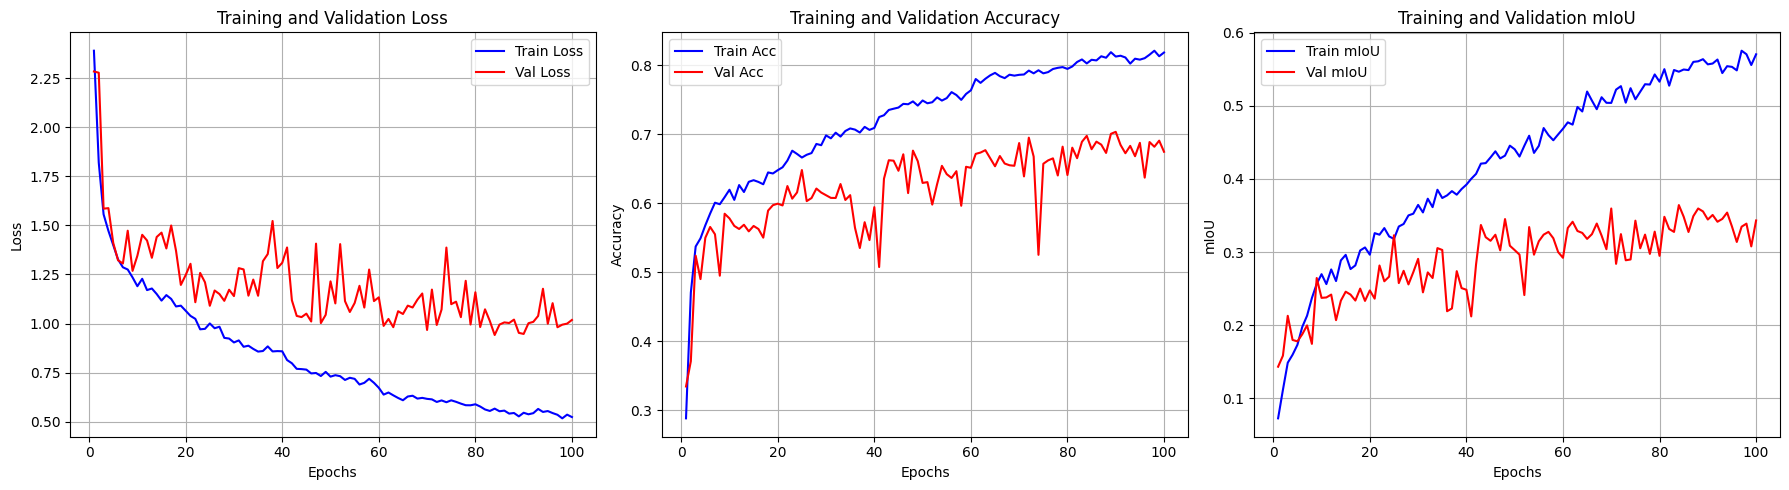

TEST set: 68 samples

FINAL EVALUATION


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]



Per-class IoU:
----------------------------------------
ceiling     : 0.8343
floor       : 0.8903
wall        : 0.5412
beam        : 0.0000
column      : 0.0247
window      : 0.2324
door        : 0.2653
chair       : 0.3061
table       : 0.3524
bookcase    : 0.4117
sofa        : 0.0000
board       : 0.0597
clutter     : 0.1651
----------------------------------------
Mean IoU: 0.3141


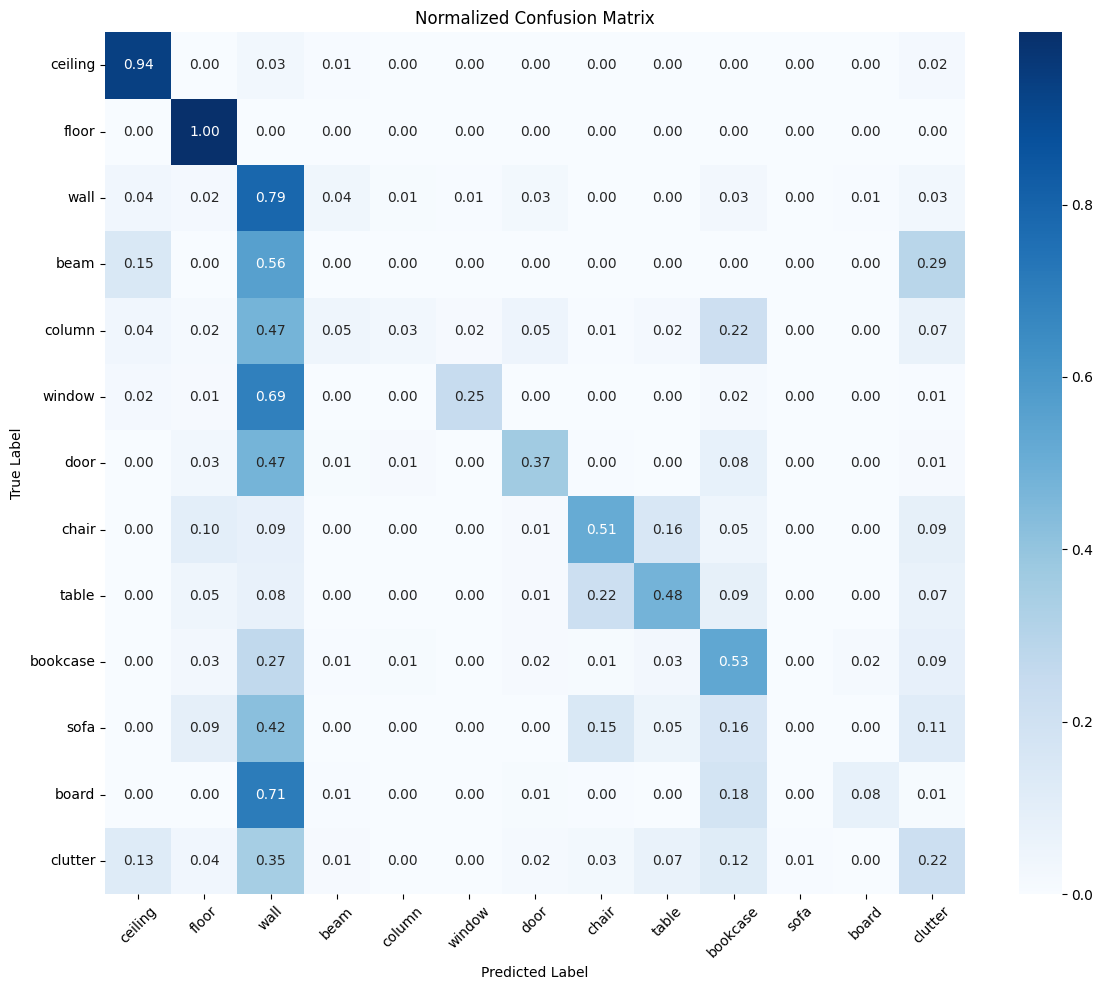


Training completed! Best mIoU: 0.3141


In [15]:
# Run training
if __name__ == "__main__":
    print("Starting PointNet training for S3DIS semantic segmentation...")
    print(f"Device: {device}")

    # Train the model
    model, metrics = main()

    # Load best model for evaluation
    model.load_state_dict(torch.load('best_pointnet_s3dis.pth'))

    # Evaluate on test set
    data_dir = './s3dis_data/processed'
    test_dataset = S3DISDataset(data_dir, num_points=4096, split='test', test_area=5)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    print("\n" + "="*60)
    print("FINAL EVALUATION")
    print("="*60)

    mean_iou, class_ious = evaluate_model(model, test_loader, device, class_names)

    print(f"\nTraining completed! Best mIoU: {mean_iou:.4f}")

TEST set: 68 samples
Visualizing model predictions...


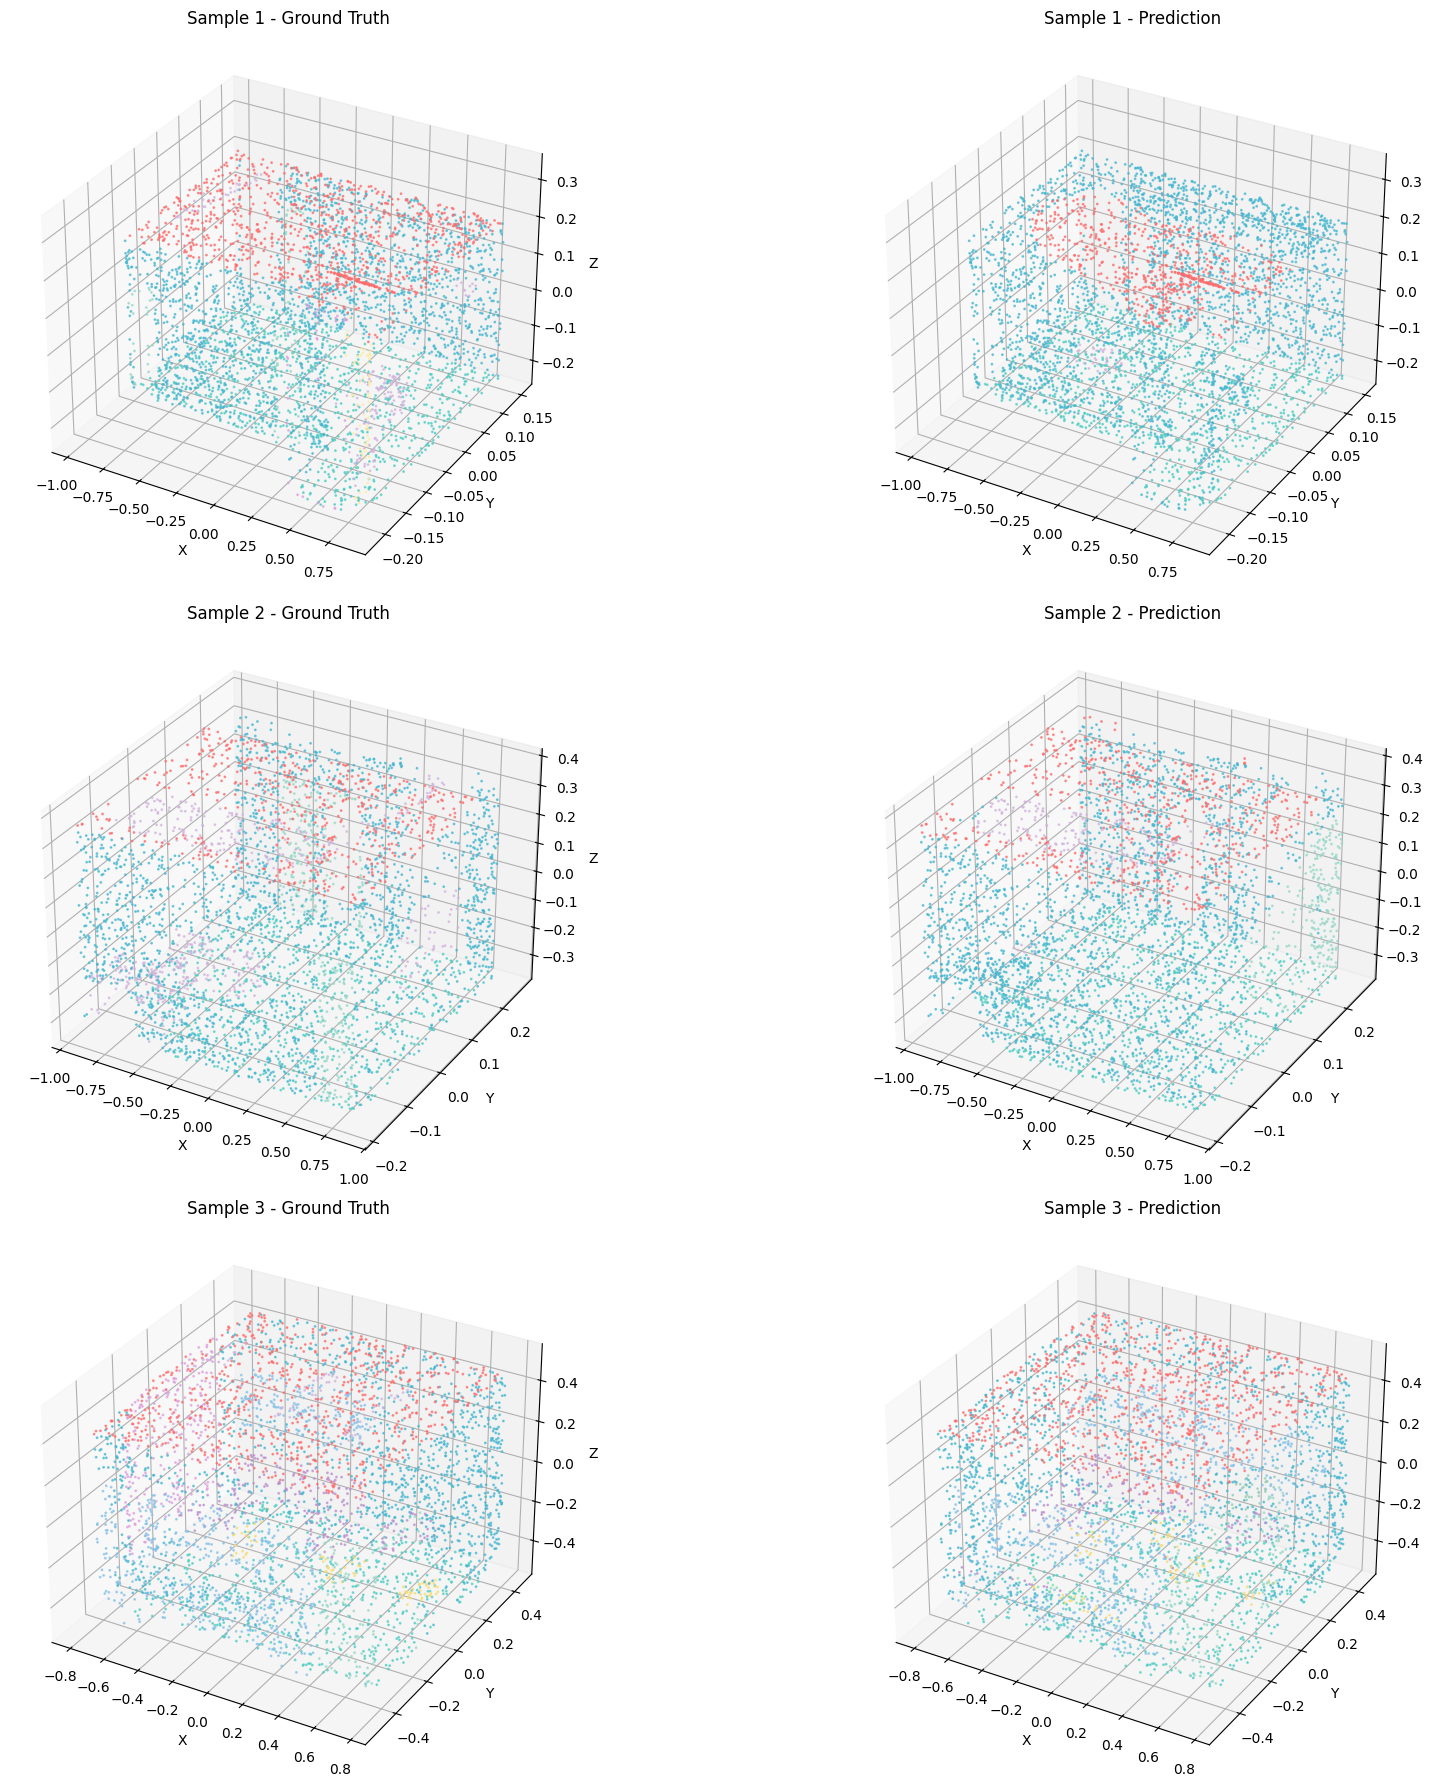

In [21]:

# Load the best trained model
model.load_state_dict(torch.load('best_pointnet_s3dis.pth'))
model.eval()

# Create test dataset and loader
data_dir = './s3dis_data/processed'
test_dataset = S3DISDataset(data_dir, num_points=4096, split='test', test_area=5)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print("Visualizing model predictions...")
print("="*50)

# Visualize some sample predictions
visualize_predictions(model, test_dataset, device, num_samples=3)

# Inference

Starting dense point cloud prediction and visualization...
Processing sample: Area_4_hallway_14
Loaded 1,084,456 points
Point cloud bounds:
  X: [0.00, 3.39]
  Y: [0.00, 5.74]
  Z: [0.00, 7.65]
Processing 1,084,456 points in chunks of 4096 with 20.0% overlap...


Processing chunks: 100%|██████████| 332/332 [00:04<00:00, 75.77it/s]


Prediction completed! Average votes per point: 1.25

Results:
Overall Accuracy: 0.5662
Mean Confidence: 0.8273

Per-class IoU for this sample:
----------------------------------------
ceiling     : 0.0364 (231,657 points)
floor       : 0.3342 (101,538 points)
wall        : 0.6125 (587,366 points)
door        : 0.0000 (25,741 points)
chair       : 0.0000 (7,744 points)
clutter     : 0.0422 (130,410 points)
----------------------------------------
Sample mIoU: 0.3866

Generating dense visualization...
Downsampled from 1,084,456 to 150,000 points for visualization


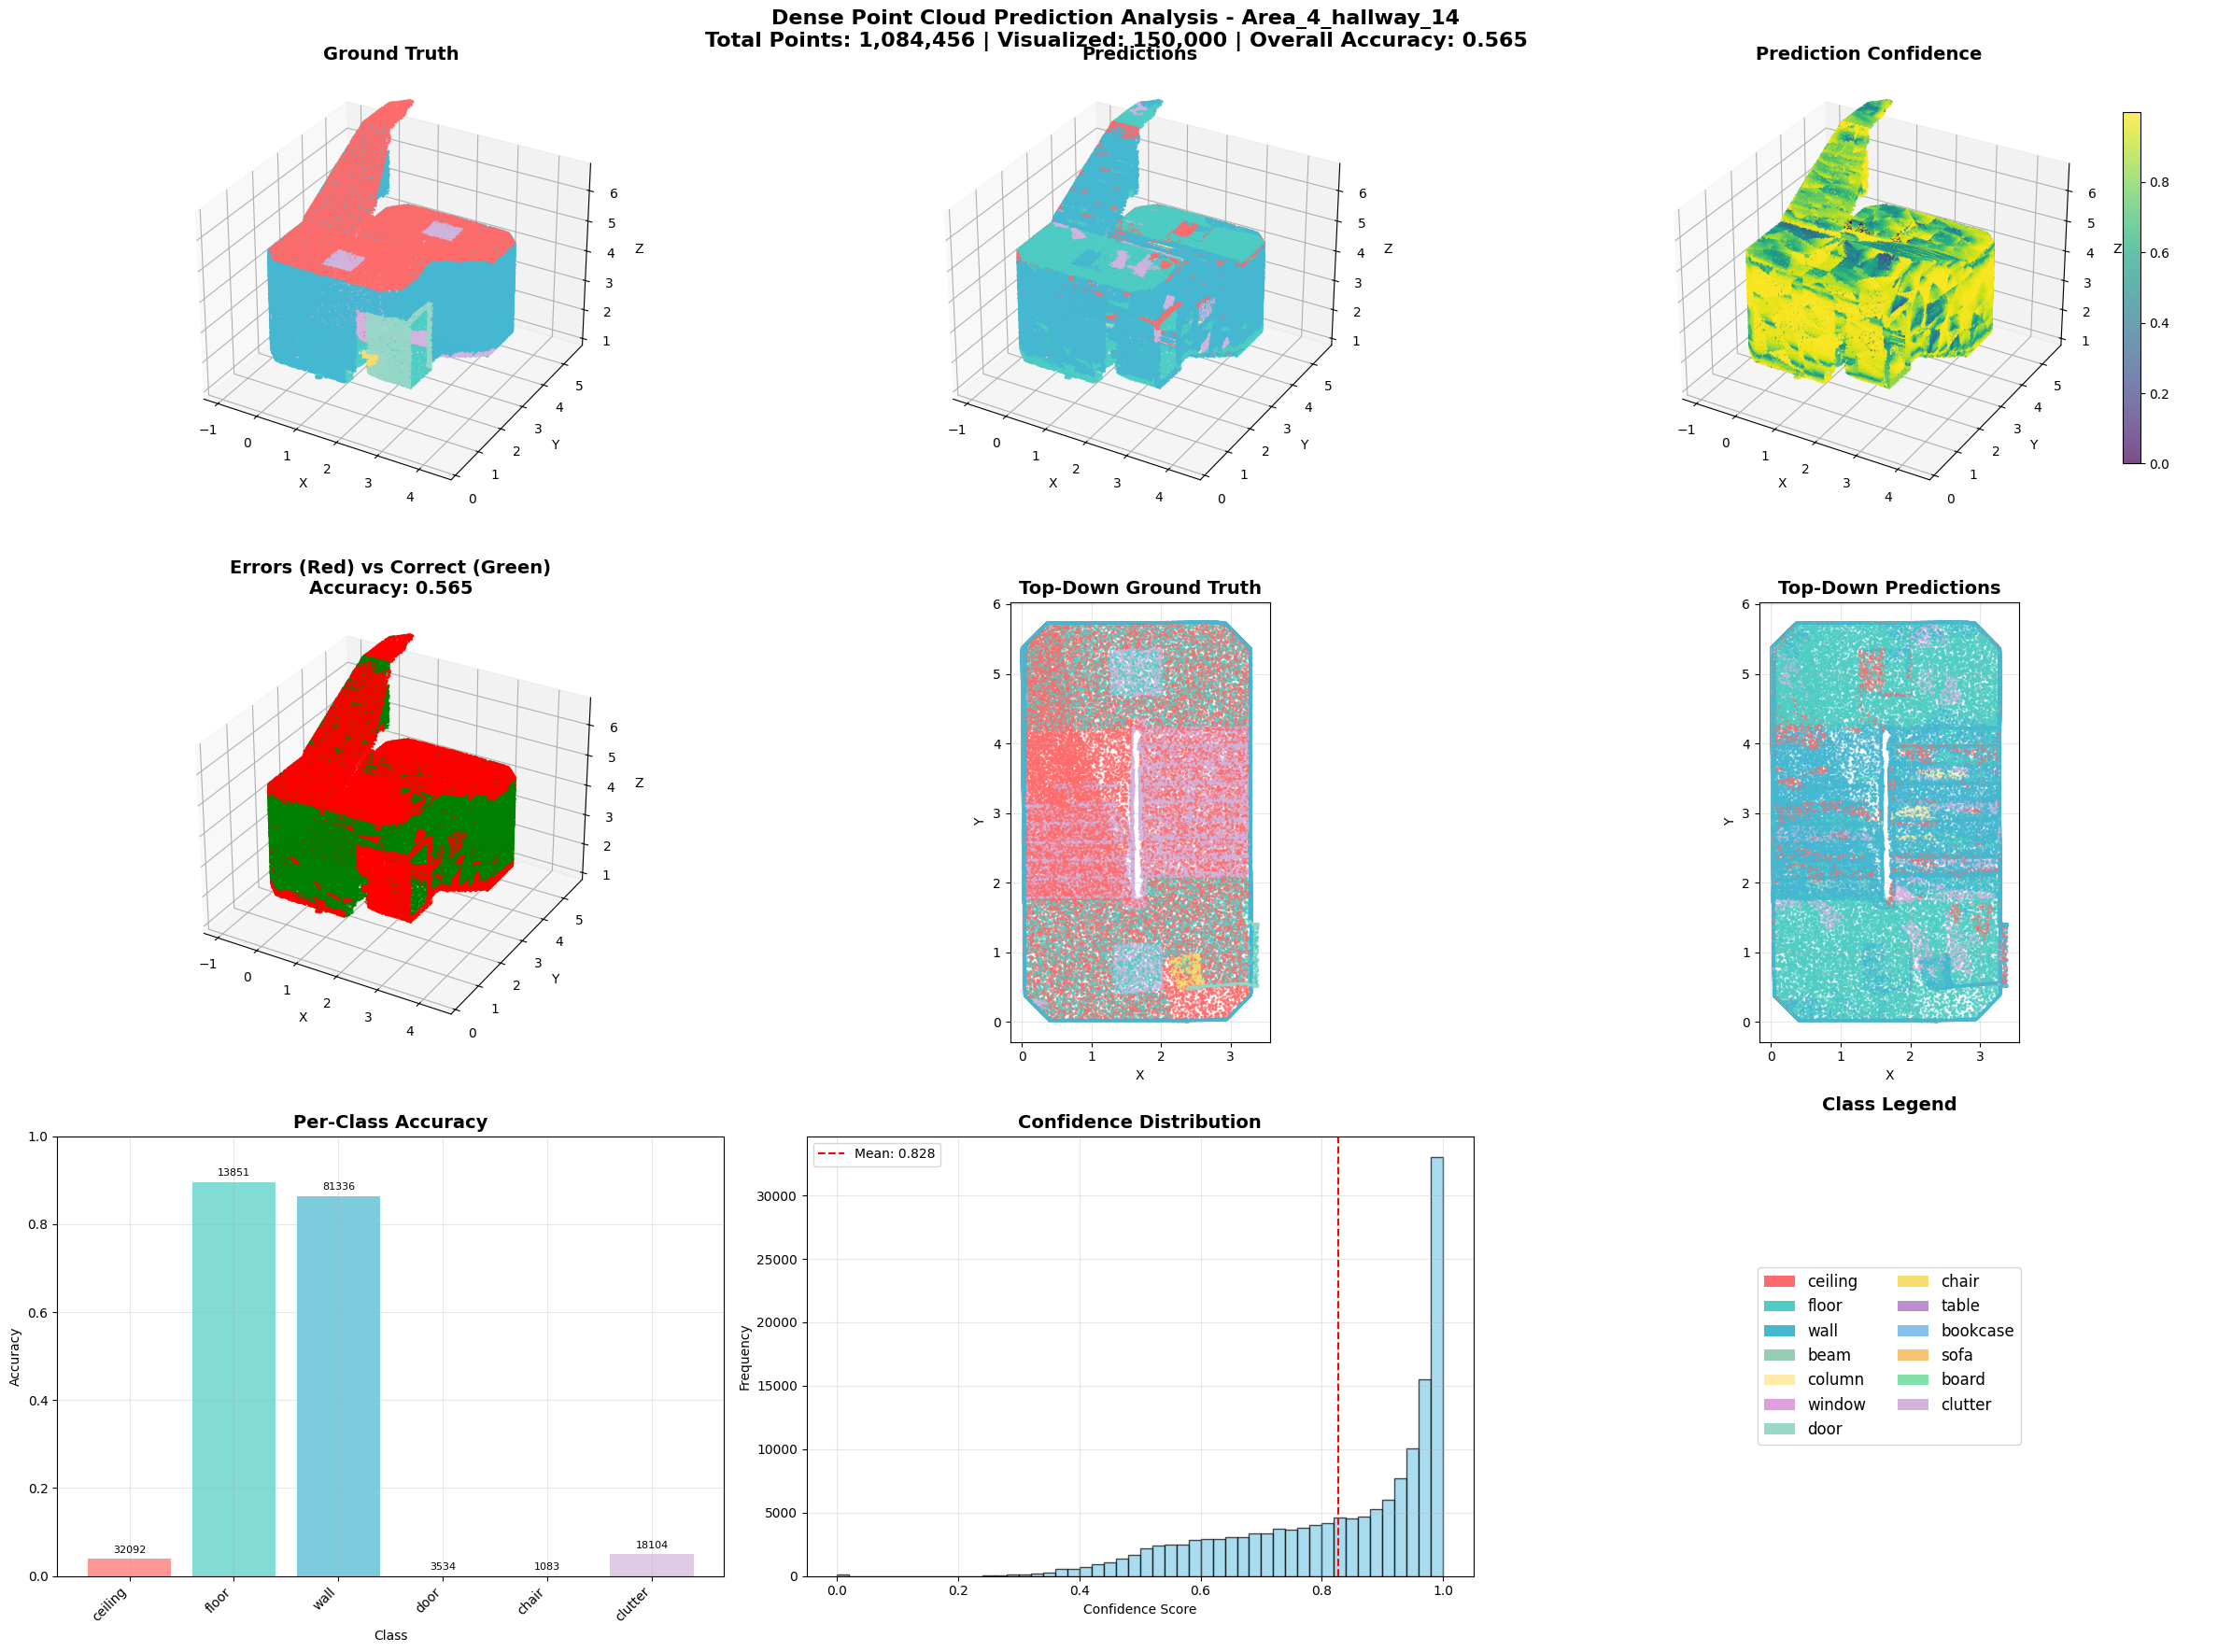


Dense prediction completed!
Final Accuracy: 0.5662
Final mIoU: 0.3866


In [24]:
def predict_full_pointcloud(model, points, device, chunk_size=4096, overlap_ratio=0.1):
    """
    Predict semantic labels for a full point cloud by processing it in overlapping chunks

    Args:
        model: Trained PointNet model
        points: Full point cloud data [N, 3] (xyz coordinates)
        device: torch device
        chunk_size: Size of each chunk to process
        overlap_ratio: Overlap between chunks to reduce boundary artifacts

    Returns:
        predictions: Predicted labels for all points [N]
        confidence: Prediction confidence scores [N]
    """
    model.eval()

    # Normalize the full point cloud
    def normalize_coords(coords):
        centroid = np.mean(coords, axis=0)
        coords_centered = coords - centroid
        m = np.max(np.sqrt(np.sum(coords_centered**2, axis=1)))
        if m > 0:
            coords_normalized = coords_centered / m
        else:
            coords_normalized = coords_centered
        return coords_normalized, centroid, m

    n_points = len(points)
    predictions = np.zeros(n_points, dtype=np.int32)
    confidence_scores = np.zeros(n_points, dtype=np.float32)
    vote_counts = np.zeros(n_points, dtype=np.int32)

    # Calculate overlap step
    step_size = int(chunk_size * (1 - overlap_ratio))

    print(f"Processing {n_points:,} points in chunks of {chunk_size} with {overlap_ratio*100}% overlap...")

    with torch.no_grad():
        for start_idx in tqdm(range(0, n_points, step_size), desc="Processing chunks"):
            end_idx = min(start_idx + chunk_size, n_points)

            # Extract chunk
            chunk_points = points[start_idx:end_idx].copy()
            actual_chunk_size = len(chunk_points)

            # If chunk is smaller than expected, pad or handle appropriately
            if actual_chunk_size < chunk_size:
                # Pad with repeated points if necessary
                if actual_chunk_size < chunk_size // 2:  # Too small, skip
                    continue
                # For the last chunk, we might want to sample to reach chunk_size
                indices = np.random.choice(actual_chunk_size, chunk_size, replace=True)
                chunk_points = chunk_points[indices]
                chunk_indices = np.arange(start_idx, end_idx)[indices]
            else:
                chunk_indices = np.arange(start_idx, end_idx)

            # Normalize chunk
            normalized_chunk, _, _ = normalize_coords(chunk_points)

            # Convert to tensor and predict
            chunk_tensor = torch.FloatTensor(normalized_chunk).unsqueeze(0).to(device)
            chunk_tensor = chunk_tensor.transpose(2, 1)  # [1, 3, N]

            pred_logits, _, _ = model(chunk_tensor)
            pred_probs = torch.softmax(pred_logits, dim=-1)
            pred_labels = pred_logits.data.max(2)[1].cpu().numpy()[0]
            pred_confidence = pred_probs.data.max(2)[0].cpu().numpy()[0]

            # Handle the case where we padded points
            if actual_chunk_size < chunk_size:
                pred_labels = pred_labels[:actual_chunk_size]
                pred_confidence = pred_confidence[:actual_chunk_size]
                chunk_indices = chunk_indices[:actual_chunk_size]

            # Accumulate votes (for overlapping regions)
            for i, idx in enumerate(chunk_indices):
                if idx < n_points:  # Safety check
                    if vote_counts[idx] == 0:
                        predictions[idx] = pred_labels[i]
                        confidence_scores[idx] = pred_confidence[i]
                    else:
                        # Average the predictions (weighted by confidence)
                        old_weight = vote_counts[idx]
                        new_weight = 1
                        total_weight = old_weight + new_weight

                        # For simplicity, use majority voting for labels
                        if pred_confidence[i] > confidence_scores[idx]:
                            predictions[idx] = pred_labels[i]

                        # Average confidence scores
                        confidence_scores[idx] = (confidence_scores[idx] * old_weight +
                                                pred_confidence[i] * new_weight) / total_weight

                    vote_counts[idx] += 1

    print(f"Prediction completed! Average votes per point: {np.mean(vote_counts):.2f}")
    return predictions, confidence_scores

def visualize_dense_prediction(points, ground_truth, predictions, confidence_scores,
                             sample_name="Dense Prediction", max_points_viz=200000):
    """
    Visualize dense point cloud predictions with multiple views

    Args:
        points: Original point cloud coordinates [N, 6] (xyz, rgb)
        ground_truth: Ground truth labels [N]
        predictions: Predicted labels [N]
        confidence_scores: Prediction confidence [N]
        sample_name: Name for the sample
        max_points_viz: Maximum points to show in 3D visualization
    """

    # Downsample for visualization if needed
    n_points = len(points)
    if n_points > max_points_viz:
        indices = np.random.choice(n_points, max_points_viz, replace=False)
        points_viz = points[indices]
        gt_viz = ground_truth[indices]
        pred_viz = predictions[indices]
        conf_viz = confidence_scores[indices]
        print(f"Downsampled from {n_points:,} to {max_points_viz:,} points for visualization")
    else:
        points_viz = points
        gt_viz = ground_truth
        pred_viz = predictions
        conf_viz = confidence_scores

    # Create comprehensive visualization
    fig = plt.figure(figsize=(24, 18))

    # 3D visualizations
    xyz = points_viz[:, :3]
    point_size = auto_point_size(len(points_viz))

    # 1. Ground Truth
    ax1 = fig.add_subplot(3, 3, 1, projection='3d')
    colors_gt = [class_colors[int(label)] for label in gt_viz]
    ax1.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=colors_gt, s=point_size, alpha=0.7)
    ax1.set_title('Ground Truth', fontsize=14, fontweight='bold')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    set_equal_aspect(ax1, xyz[:, 0], xyz[:, 1], xyz[:, 2], zoom=0.8)

    # 2. Predictions
    ax2 = fig.add_subplot(3, 3, 2, projection='3d')
    colors_pred = [class_colors[int(label)] for label in pred_viz]
    ax2.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=colors_pred, s=point_size, alpha=0.7)
    ax2.set_title('Predictions', fontsize=14, fontweight='bold')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    set_equal_aspect(ax2, xyz[:, 0], xyz[:, 1], xyz[:, 2], zoom=0.8)

    # 3. Confidence visualization
    ax3 = fig.add_subplot(3, 3, 3, projection='3d')
    scatter = ax3.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=conf_viz,
                         s=point_size, alpha=0.7, cmap='viridis')
    ax3.set_title('Prediction Confidence', fontsize=14, fontweight='bold')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    set_equal_aspect(ax3, xyz[:, 0], xyz[:, 1], xyz[:, 2], zoom=0.8)
    plt.colorbar(scatter, ax=ax3, shrink=0.8, aspect=20)

    # 4. Error visualization (red = wrong, green = correct)
    ax4 = fig.add_subplot(3, 3, 4, projection='3d')
    error_mask = (gt_viz != pred_viz)
    colors_error = ['red' if error else 'green' for error in error_mask]
    ax4.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=colors_error, s=point_size, alpha=0.7)
    ax4.set_title(f'Errors (Red) vs Correct (Green)\nAccuracy: {(1-np.mean(error_mask)):.3f}',
                 fontsize=14, fontweight='bold')
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    ax4.set_zlabel('Z')
    set_equal_aspect(ax4, xyz[:, 0], xyz[:, 1], xyz[:, 2], zoom=0.8)

    # 5-6. Top-down views
    ax5 = fig.add_subplot(3, 3, 5)
    ax5.scatter(xyz[:, 0], xyz[:, 1], c=colors_gt, s=point_size*2, alpha=0.6)
    ax5.set_title('Top-Down Ground Truth', fontsize=14, fontweight='bold')
    ax5.set_xlabel('X')
    ax5.set_ylabel('Y')
    ax5.set_aspect('equal')
    ax5.grid(True, alpha=0.3)

    ax6 = fig.add_subplot(3, 3, 6)
    ax6.scatter(xyz[:, 0], xyz[:, 1], c=colors_pred, s=point_size*2, alpha=0.6)
    ax6.set_title('Top-Down Predictions', fontsize=14, fontweight='bold')
    ax6.set_xlabel('X')
    ax6.set_ylabel('Y')
    ax6.set_aspect('equal')
    ax6.grid(True, alpha=0.3)

    # 7. Class-wise accuracy
    ax7 = fig.add_subplot(3, 3, 7)
    class_accuracies = []
    class_counts = []
    present_classes = []

    for cls in range(len(class_names)):
        mask = (gt_viz == cls)
        if mask.sum() > 0:
            acc = np.mean(pred_viz[mask] == cls)
            class_accuracies.append(acc)
            class_counts.append(mask.sum())
            present_classes.append(class_names[cls])

    bars = ax7.bar(range(len(present_classes)), class_accuracies,
                   color=[class_colors[class_names.index(name)] for name in present_classes],
                   alpha=0.7)
    ax7.set_xlabel('Class')
    ax7.set_ylabel('Accuracy')
    ax7.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    ax7.set_xticks(range(len(present_classes)))
    ax7.set_xticklabels(present_classes, rotation=45, ha='right')
    ax7.set_ylim(0, 1)
    ax7.grid(True, alpha=0.3)

    # Add count labels on bars
    for bar, count in zip(bars, class_counts):
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{count}', ha='center', va='bottom', fontsize=8)

    # 8. Confidence distribution
    ax8 = fig.add_subplot(3, 3, 8)
    ax8.hist(conf_viz, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax8.axvline(np.mean(conf_viz), color='red', linestyle='--',
                label=f'Mean: {np.mean(conf_viz):.3f}')
    ax8.set_xlabel('Confidence Score')
    ax8.set_ylabel('Frequency')
    ax8.set_title('Confidence Distribution', fontsize=14, fontweight='bold')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # 9. Class legend
    ax9 = fig.add_subplot(3, 3, 9)
    ax9.axis('off')
    legend_elements = [Patch(facecolor=class_colors[i], label=class_names[i])
                      for i in range(len(class_names))]
    ax9.legend(handles=legend_elements, loc='center', fontsize=12, ncol=2)
    ax9.set_title('Class Legend', fontsize=14, fontweight='bold', pad=20)

    plt.suptitle(f'Dense Point Cloud Prediction Analysis - {sample_name}\n'
                f'Total Points: {n_points:,} | Visualized: {len(points_viz):,} | '
                f'Overall Accuracy: {np.mean(gt_viz == pred_viz):.3f}',
                fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()

def process_and_visualize_dense_sample(model, data_dir, device, sample_idx=None, chunk_size=4096):
    """
    Process a full sample with dense prediction and visualization

    Args:
        model: Trained model
        data_dir: Directory containing processed data
        device: torch device
        sample_idx: Index of sample to process (if None, random sample)
        chunk_size: Size of chunks for processing
    """

    # Get available files
    point_files = [f for f in os.listdir(data_dir) if f.endswith('_point.npy')]

    if sample_idx is None:
        sample_idx = random.randint(0, len(point_files) - 1)

    selected_file = point_files[sample_idx]
    base_name = selected_file.replace('_point.npy', '')

    print(f"Processing sample: {base_name}")
    print("="*50)

    # Load full data
    points = np.load(os.path.join(data_dir, f'{base_name}_point.npy'))
    sem_labels = np.load(os.path.join(data_dir, f'{base_name}_sem_label.npy'))

    print(f"Loaded {len(points):,} points")
    print(f"Point cloud bounds:")
    print(f"  X: [{points[:, 0].min():.2f}, {points[:, 0].max():.2f}]")
    print(f"  Y: [{points[:, 1].min():.2f}, {points[:, 1].max():.2f}]")
    print(f"  Z: [{points[:, 2].min():.2f}, {points[:, 2].max():.2f}]")

    # Extract coordinates for prediction
    coords = points[:, :3].astype(np.float32)

    # Predict on full point cloud
    predictions, confidence_scores = predict_full_pointcloud(
        model, coords, device, chunk_size=chunk_size, overlap_ratio=0.2
    )

    # Calculate overall metrics
    overall_accuracy = np.mean(predictions == sem_labels)
    mean_confidence = np.mean(confidence_scores)

    print(f"\nResults:")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Mean Confidence: {mean_confidence:.4f}")

    # Calculate per-class IoU for this sample
    print(f"\nPer-class IoU for this sample:")
    print("-" * 40)
    class_ious = []
    for cls in range(len(class_names)):
        pred_cls = (predictions == cls)
        target_cls = (sem_labels == cls)

        if target_cls.sum() == 0:
            if pred_cls.sum() == 0:
                iou = 1.0
            else:
                iou = 0.0
        else:
            intersection = (pred_cls & target_cls).sum()
            union = (pred_cls | target_cls).sum()
            iou = intersection / union if union > 0 else 0.0

        class_ious.append(iou)
        if target_cls.sum() > 0:  # Only print classes that exist in ground truth
            print(f"{class_names[cls]:12s}: {iou:.4f} ({target_cls.sum():,} points)")

    sample_miou = np.mean(class_ious)
    print("-" * 40)
    print(f"Sample mIoU: {sample_miou:.4f}")

    # Visualize results
    print(f"\nGenerating dense visualization...")
    visualize_dense_prediction(points, sem_labels, predictions, confidence_scores,
                             sample_name=base_name, max_points_viz=150000)

    return predictions, confidence_scores, overall_accuracy, sample_miou

# Execute the dense visualization function
print("Starting dense point cloud prediction and visualization...")
print("="*60)

# Process and visualize a dense sample
predictions, confidence_scores, accuracy, miou = process_and_visualize_dense_sample(
    model, data_dir, device, sample_idx=None, chunk_size=4096
)

print(f"\nDense prediction completed!")
print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final mIoU: {miou:.4f}")

Starting dense point cloud prediction and visualization...
Processing sample: Area_4_hallway_7
Loaded 1,588,544 points
Point cloud bounds:
  X: [0.00, 14.38]
  Y: [0.00, 5.61]
  Z: [0.00, 2.86]
Processing 1,588,544 points in chunks of 4096 with 20.0% overlap...


Processing chunks: 100%|██████████| 485/485 [00:06<00:00, 75.62it/s]


Prediction completed! Average votes per point: 1.25

Results:
Overall Accuracy: 0.4853
Mean Confidence: 0.8411

Per-class IoU for this sample:
----------------------------------------
ceiling     : 0.0000 (303,975 points)
floor       : 0.4438 (351,830 points)
wall        : 0.5008 (486,665 points)
door        : 0.0000 (197,906 points)
clutter     : 0.0489 (248,168 points)
----------------------------------------
Sample mIoU: 0.6149

Generating dense visualization...
Downsampled from 1,588,544 to 150,000 points for visualization


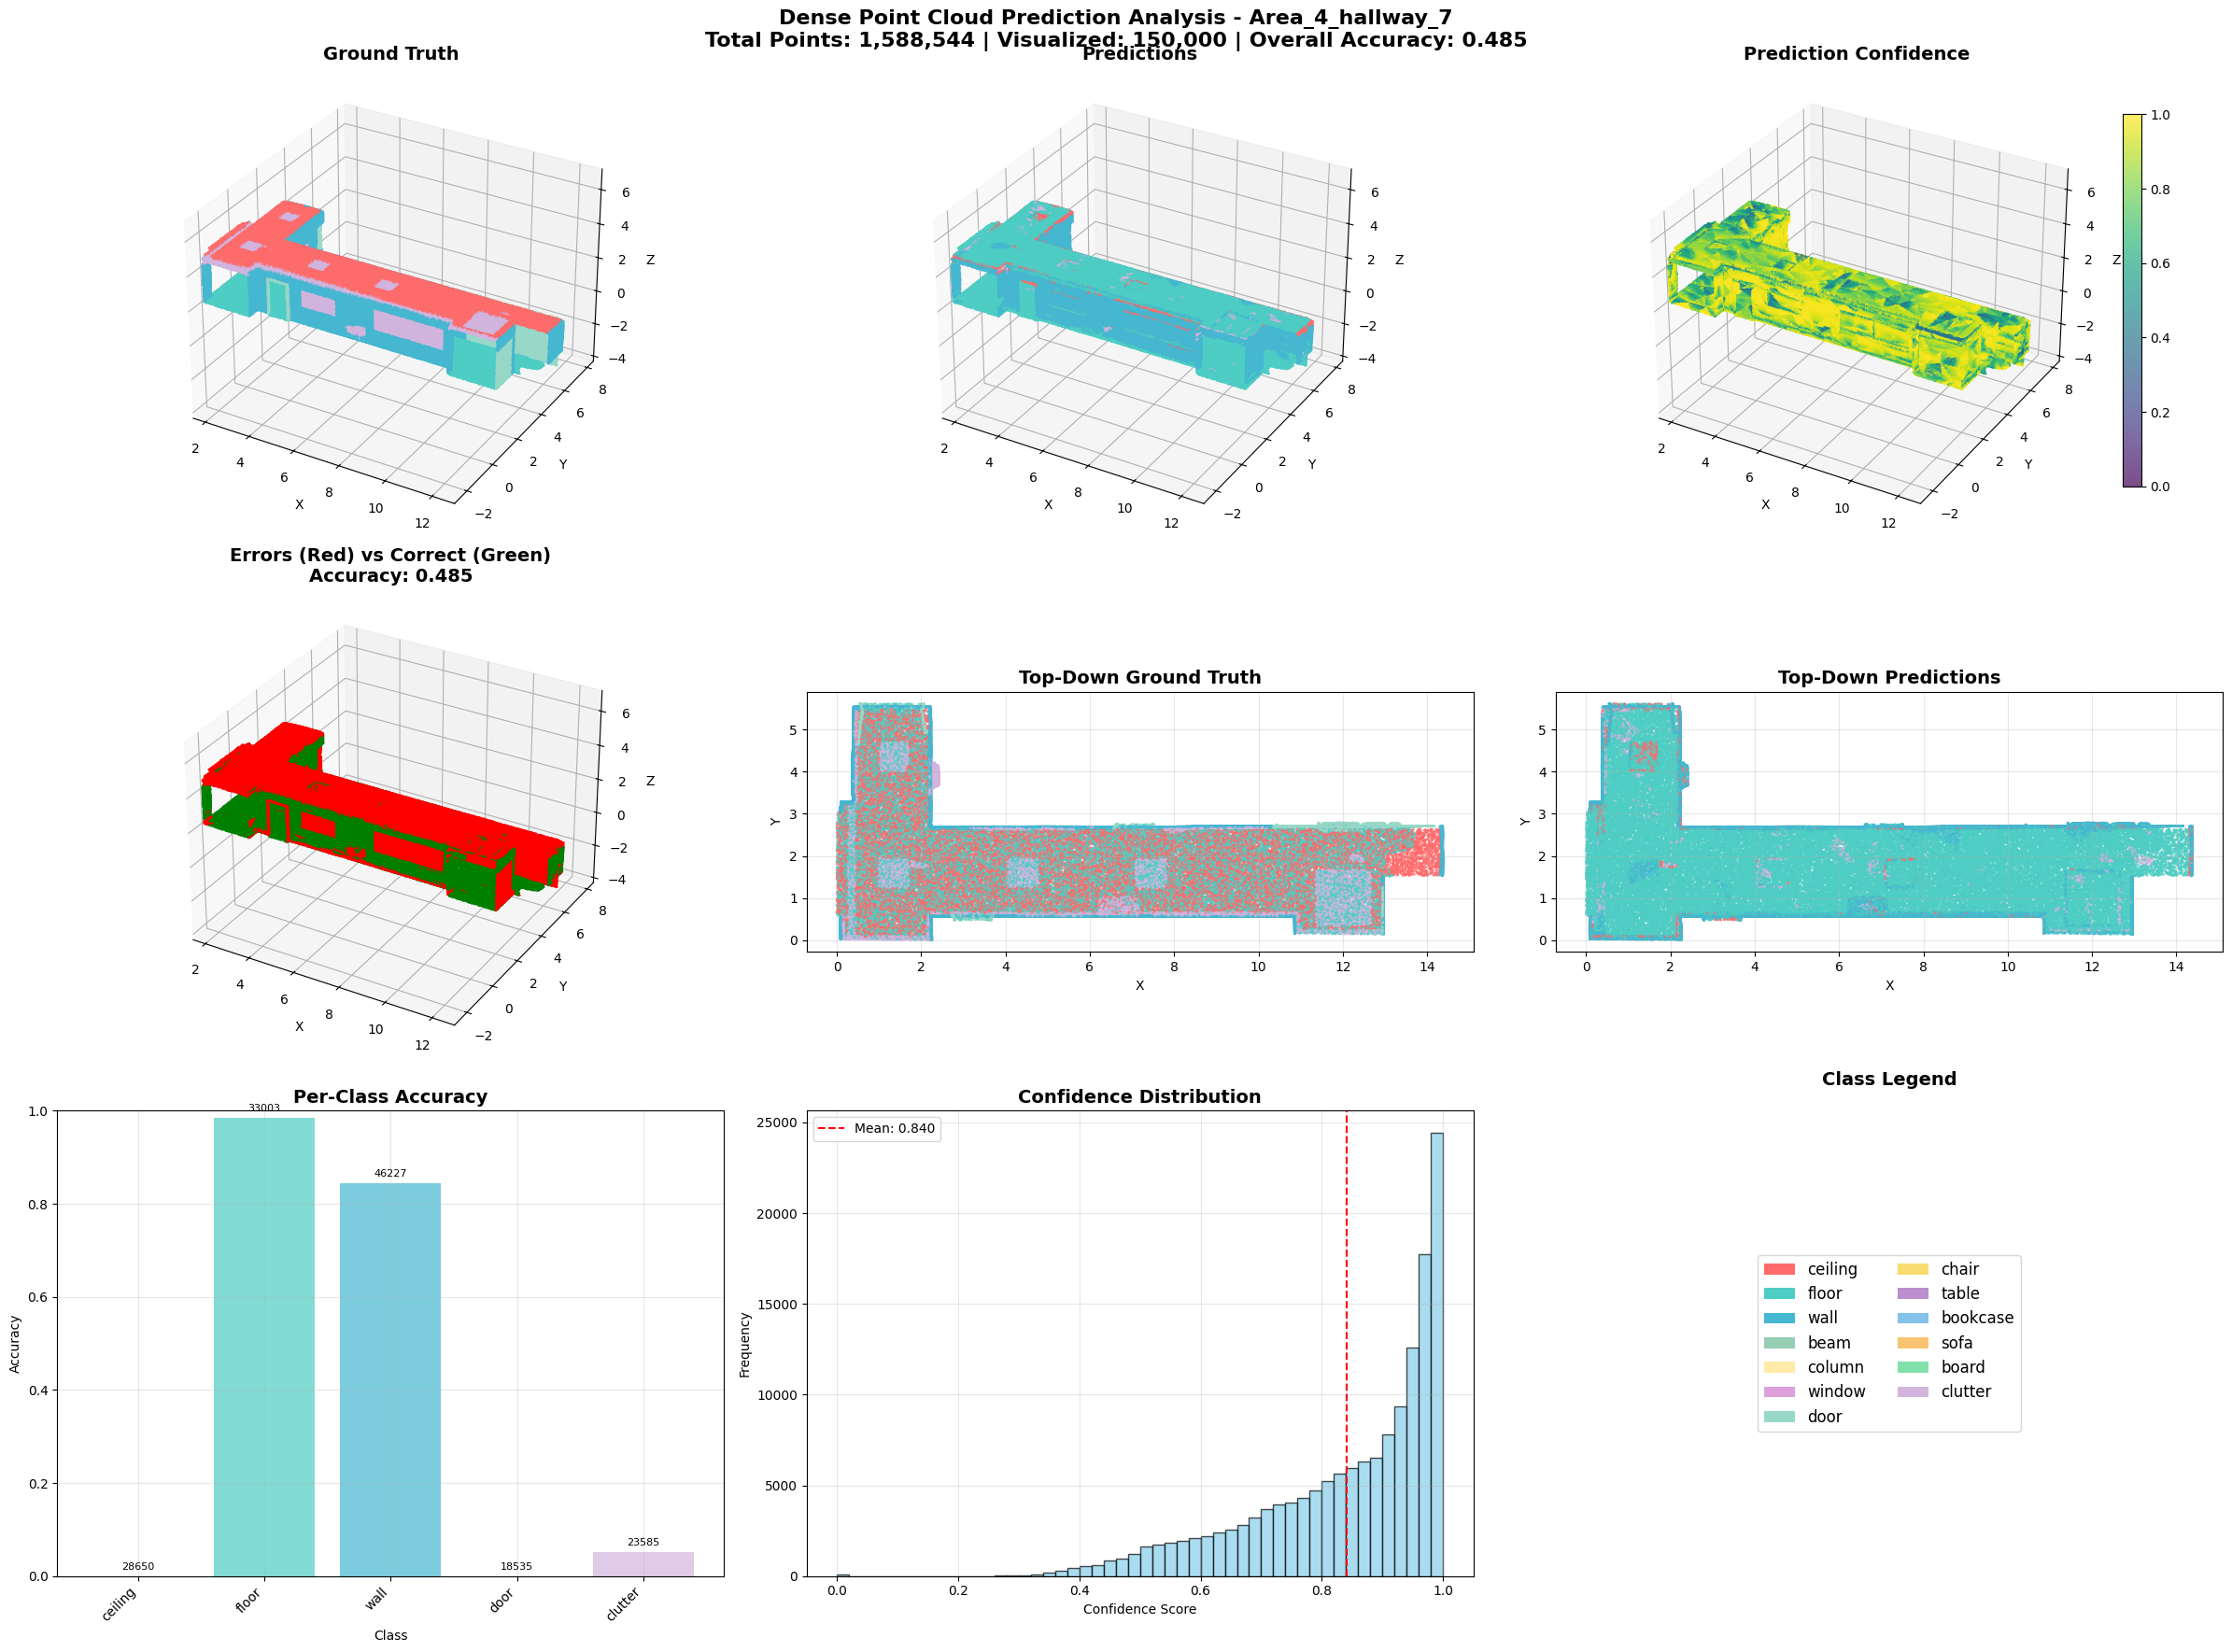


Dense prediction completed!
Final Accuracy: 0.4853
Final mIoU: 0.6149


In [27]:

# Execute the dense visualization function
print("Starting dense point cloud prediction and visualization...")
print("="*60)

# Process and visualize a dense sample
predictions, confidence_scores, accuracy, miou = process_and_visualize_dense_sample(
    model, data_dir, device, sample_idx=None, chunk_size=4096
)

print(f"\nDense prediction completed!")
print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final mIoU: {miou:.4f}")